# import modules

In [2]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED
from datetime import datetime, timedelta
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
import pysam
import pyranges
import pybedtools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import preprocessing
import scipy as sp
import scanpy as sc
from sklearn.cluster import KMeans
from adjustText import adjust_text
# import episcanpy

import SCRIPT.enrichment
from SCRIPT.utilities import utils
from SCRIPT.utilities.utils import print_log
# from giggle import Giggle

In [3]:
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False

In [15]:
a = yaml.load("""a:\n  b: 2\n  c: 3\n""")

In [16]:
with open('./test.yml', 'w+') as f:
    yaml.dump(a,f)

In [18]:
def read_SingleCellExperiment_rds(input_RDS):
    import anndata2ri
    from rpy2.robjects import r
    anndata2ri.activate()
    rscript = 'readRDS("{RDS_file_path}")'.format(RDS_file_path = input_RDS)
    adata = r(rscript)
    adata.var.columns = [str(i) for i in adata.var.columns]
    adata.obs.columns = [str(i) for i in adata.obs.columns]
    return adata

In [ ]:
sc.settings.verbosity = 3
# sc.logging.print_header()
sc.logging.print_versions()

# Config

In [5]:
plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'bold',
    'figure.titleweight': 'bold',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'bold',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [4]:
human_chip_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/human_ChIP_index'
human_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/human_motif_index'
mouse_chip_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_ChIP_index'
mouse_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_motif_index'

In [3]:
I_tf_list = ['I_TBX21', 'I_IRF8', 'I_CEBPA', 'I_CEBPB', 'I_MYB', 'I_BCL11A', 'I_BCL11B', 'I_STAT1', 'I_SOX10', 'I_EBF1', 'I_BRD4']
C_tf_list = [i.replace('I_', 'C_') for i in I_tf_list]
non_tf_list = [i.replace('I_', '') for i in I_tf_list]

In [114]:
def cal_deviation(val, mean, std):
    return (val-mean)/std


def cal_deviation_table(fg_table, bg_table, i):
    print_log('chunk {i} calculating ...'.format(i=i))
    dts_cell_result_table_deviation = fg_table.copy()
    for factor in fg_table.index:
        factor_bg = bg_table.loc[factor, :].tolist()
        bg_mean = np.mean(factor_bg)
        bg_std = np.std(factor_bg)
        if bg_mean != 0 and bg_std != 0:
            dts_cell_result_table_deviation.loc[factor, :] = fg_table.loc[factor, :].apply(
                cal_deviation, **{'mean': bg_mean, 'std': bg_std})
        else:
            dts_cell_result_table_deviation.loc[factor, :] = 0
    print_log('chunk {i} finished calculation!'.format(i=i))
    return dts_cell_result_table_deviation


def cal_deviation_table_batch(fg_table, bg_table, n_cores=8):
    print_log("Calculating deviation, divide into {n} chunks...".format(n=n_cores))
    fg_table_split = np.array_split(fg_table, n_cores)
    args = [[table, bg_table, i] for (i, table) in enumerate(fg_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_deviation_table, args)
    print_log("Generating P value table ...")
    dts_cell_result_table_deviation = pd.concat([i for i in result])
    print_log('Finished calculation enrichment!')
    return dts_cell_result_table_deviation

## RP calculation

In [9]:
# def ExtractGeneInfo(gene_bed):
#     """Extract gene information from gene bed file."""

#     bed = pd.read_csv(gene_bed, sep="\t", header=0, index_col=False)
#     bed['transcript'] = [x.strip().split(".")[0] for x in bed['name'].tolist()]
#     bed['tss'] = bed.apply(lambda x: x['txStart'] if x['strand']=='+' else x['txEnd'], axis=1)

#     ### adjacent P+GB
#     bed["start"] = bed.apply(lambda x: x['txStart']-2000 if x['strand']=='+' else x['txStart'], axis=1)
#     bed["end"] = bed.apply(lambda x: x['txEnd']+2000 if x['strand']=='-' else x['txEnd'], axis=1)
    
#     bed['promoter'] = bed.apply(lambda x: tuple([x['tss']-2000, x['tss']+2000]), axis=1)
#     bed['exons'] = bed.apply(lambda x: tuple([(int(i), int(j)) for i, j in zip(x['exonStarts'].strip(',').split(','), x['exonEnds'].strip(',').split(','))]), axis=1)

#     ### exon length
#     bed['length'] = bed.apply(lambda x: sum(list(map(lambda i: (i[1]-i[0])/1000.0, x['exons']))), axis=1)
#     bed['uid'] = bed.apply(lambda x: "%s@%s@%s"%(x['name2'], x['start'], x['end']), axis=1)
#     bed = bed.drop_duplicates(subset='uid', keep="first")
#     gene_info = []
#     for irow, x in bed.iterrows():
#         gene_info.append([x['chrom'], x['start'], x['end'], x['tss'], x['promoter'], x['exons'], x['length'], 1, x['uid']])
#     ### [chrom_0, start_1, end_2, tss_3, promoter_4, exons_5, length_6(kb), 1_7, uid_8(genename@start@end)]
#     return gene_info

In [117]:
def geneInfoSimple(gene_bed):
    genes_info = []
    genes_list = []
    fhd = open(gene_bed, 'rt')
    fhd.readline() # skip the first line. In our current gene txt file, there is no '#' in the first line. We need to, perhaps, use the 'ExtractGeneInfo' function.
    for line in fhd:
        line = line.strip().split('\t')
        if not line[0].startswith('#'):
            if line[3] == "+":
                genes_info.append((line[2], int(line[4]), 1, "%s@%s@%s" % (line[12], line[2], line[4])))
            else:
                genes_info.append((line[2], int(line[5]), 1, "%s@%s@%s" % (line[12], line[2], line[5])))
                # gene_info [chrom, tss, 1, gene_unique]
    fhd.close()
    genes_info = list(set(genes_info))
    for igene in range(len(genes_info)):
        tmp_gene = list(genes_info[igene])
        genes_list.append(tmp_gene[3])
        tmp_gene[3] = igene
        genes_info[igene] = tmp_gene
    return genes_info, genes_list

In [118]:
def RP_Simple(peaks_info, genes_info, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    gene_distance = 15 * decay
    genes_peaks_score_array = sp.sparse.dok_matrix((len(genes_info), len(peaks_info)), dtype=np.float64)

    w = genes_info + peaks_info

    A = {}

    w.sort()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(elem[1] - g[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(g[1] - elem[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    return(genes_peaks_score_array)

In [119]:
def cal_neighbor_cell_peak_mat(table, input_mat, coor_table, impute_n, i):
    print(i)
    for cell_barcode in table.index:
        nearest_bc = find_nearest_cells(cell_barcode, coor_table, n_neighbor=impute_n)
#         table.loc[cell_barcode,:] = [1 if i else 0 for i in input_mat.loc[nearest_bc,:].sum() >= 1]
        table.loc[cell_barcode,:] = input_mat.loc[nearest_bc,:].sum()
    return table

def cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, impute_n, n_cores=8):
    print_log("Calculating enrichment, divide into {n} chunks...".format(n=n_cores))
    input_table_split = np.array_split(input_mat, n_cores)
    args = [[table, input_mat, coor_table, impute_n, i] for (i, table) in enumerate(input_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_neighbor_cell_peak_mat, args)
    cell_peak = pd.concat([i for i in result])
    print_log('finished!')
#     return sp.sparse.csr_matrix(cell_peak)
    return cell_peak

In [256]:
tmp = fg_dataset_odds_ratio_df_ChIP*

In [255]:
fg_dataset_odds_ratio_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_odds_ratio_df_ChIP.pk')
fg_dataset_fisher_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_fisher_df_ChIP.pk')
fg_dataset_peak_norm_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_peak_norm_df_ChIP.pk')

In [89]:
bg_dataset_odds_ratio_df = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_odds_ratio_df_ChIP.pk')
bg_dataset_fisher_df = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_fisher_df_ChIP.pk')
bg_peak_number_norm_coef = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_peak_norm_df_ChIP.pk')

In [33]:
bg_dataset_score_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_score_df_ChIP.pk')

In [72]:
def score_normalization(dataset_odds_ratio_df, dataset_fisher_df, peak_number_norm_coef):
    # fisher normalize matrix
    fisher_log_foreground = -np.log10(dataset_fisher_df)
    fisher_log_foreground_true_table = (fisher_log_foreground.T/fisher_log_foreground.max(1)).T
    fisher_log_foreground_true_table = fisher_log_foreground_true_table.reindex(
        index=dataset_odds_ratio_df.index, columns=dataset_odds_ratio_df.columns)

    peak_number_norm_coef_table = peak_number_norm_coef.reindex(
        index=dataset_odds_ratio_df.index, columns=dataset_odds_ratio_df.columns)

    # key multiply
    fg_dataset_cell_score_df = dataset_odds_ratio_df * fisher_log_foreground_true_table * peak_number_norm_coef_table
    return fg_dataset_cell_score_df


def cal_peak_norm_matrix(index_peak_number_path, peaks_number_path):
    index_peak_number = pd.read_csv(index_peak_number_path, sep='\t', header=None, index_col=0)
    data_peak_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)
    data_peak_number.index = data_peak_number.index.astype(str)
    peak_cell_index_norm_table = pd.DataFrame(np.zeros([index_peak_number.index.__len__(), data_peak_number.index.__len__()]),
                                              index=index_peak_number.index, columns=data_peak_number.index)
    for dts in peak_cell_index_norm_table.index:
        dts_number = index_peak_number.loc[dts, 1]
        peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in data_peak_number[1]]
    peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=index_peak_number.index, columns=data_peak_number.index)

    peak_number_dts_mean_value = data_peak_number[1].mean()
    peak_number_dts_norm_series = data_peak_number[1].apply(lambda x: 2**-(abs(x-peak_number_dts_mean_value)/x))
    peak_number_dts_norm_series = peak_number_dts_norm_series.reindex(index=data_peak_number.index)

    peak_number_norm_coef = peak_cell_index_norm_table * peak_number_dts_norm_series

    return peak_number_norm_coef

In [86]:
peak_normal = cal_peak_norm_matrix('/mnt/Storage/home/dongxin/Projects/scATAC/index/human_motif_index/peaks_number.txt', 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_peaks_number.txt')

In [87]:
utils.store_to_pickle(peak_normal, 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_peak_norm_df_motif.pk')

In [96]:
fg_score = score_normalization(fg_dataset_odds_ratio_df_ChIP, fg_dataset_fisher_df_ChIP, fg_dataset_peak_norm_df_ChIP)

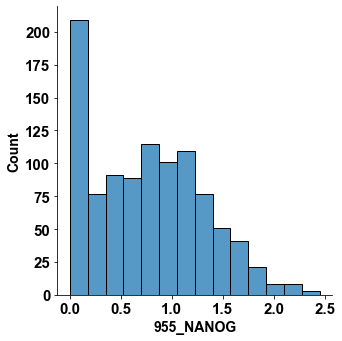

In [107]:
sns.displot(bg_score.loc['955_NANOG',:])

In [99]:
bg_score.loc['1006_EOMES',:].std()

0.12908773611174681

In [102]:
bg_score.loc['1006_EOMES',:].mean()

0.12465974328094981

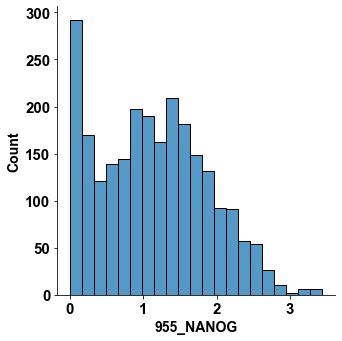

In [108]:
sns.displot(fg_score.loc['955_NANOG',:])

In [101]:
fg_score.loc['1006_EOMES',:].max()

3.602432780234723

In [104]:
3.477773036953773/0.12908773611174681

26.941157554604448

In [97]:
utils.store_to_pickle(fg_score, 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files//fg_dataset_score_df_ChIP.pk')

In [61]:
fisher_log_foreground_true_table.columns

Index(['98', '9', '83', '142', '279', '220', '6', '270', '293', '166',
       ...
       '997', '921', '967', '910', '996', '875', '924', '889', '928', '953'],
      dtype='object', length=1000)

In [118]:
fg_dev = cal_deviation_table_batch(fg_score, bg_score, 16)

INFO 2021-06-20 18:07:58 Calculating deviation, divide into 16 chunks...
INFO 2021-06-20 18:08:10 chunk 0 calculating ...
INFO 2021-06-20 18:08:13 chunk 1 calculating ...
INFO 2021-06-20 18:08:14 chunk 2 calculating ...
INFO 2021-06-20 18:08:16 chunk 0 finished calculation!
INFO 2021-06-20 18:08:16 chunk 3 calculating ...
INFO 2021-06-20 18:08:17 chunk 1 finished calculation!
INFO 2021-06-20 18:08:18 chunk 4 calculating ...
INFO 2021-06-20 18:08:18 chunk 2 finished calculation!
INFO 2021-06-20 18:08:20 chunk 3 finished calculation!
INFO 2021-06-20 18:08:22 chunk 5 calculating ...
INFO 2021-06-20 18:08:24 chunk 6 calculating ...
INFO 2021-06-20 18:08:24 chunk 4 finished calculation!
INFO 2021-06-20 18:08:25 chunk 7 calculating ...
INFO 2021-06-20 18:08:27 chunk 5 finished calculation!
INFO 2021-06-20 18:08:28 chunk 8 calculating ...
INFO 2021-06-20 18:08:28 chunk 6 finished calculation!
INFO 2021-06-20 18:08:29 chunk 9 calculating ...
INFO 2021-06-20 18:08:30 chunk 7 finished calculatio

In [122]:
fg_dev

id
72394_POLR2A      0.031624
43080_POLR2A      0.082469
83748_FAM208A     0.398160
73713_AFF1        0.776134
46258_TAF1        0.846626
                   ...    
77052_ZNF736     57.289582
57305_EP300      60.061286
85129_SETDB1     73.091787
71056_SETDB1     73.977793
76140_H2AFX      77.941330
Length: 4501, dtype: float64

In [123]:
fg_dev

,singles-BM0828-CLP-frozen-151103-13,singles-BM0828-LMPP-frozen-151105-40,singles-BM0828-MPP-frozen-151103-43,singles-BM0828-HSC-fresh-151027-37,singles-BM0828-MPP-frozen-151103-60,singles-BM0828-GMP-151027-11,singles-BM0828-MPP-frozen-151103-8,singles-MEP-141017-52,singles-BM0828-CMP-frozen-151118-66,singles-BM0828-CMP-frozen-151118-49,...,singles-160818-BM1137-pDC-LS-59,singles-160819-BM1137-CMP-LS-21,singles-160822-BM1137-CMP-LS-15,singles-160822-BM1137-CMP-LS-62,singles-160822-BM1137-CMP-LS-96,singles-160822-BM1137-CMP-LS-11,singles-160818-BM1137-pDC-LS-70,singles-160822-BM1137-CMP-LS-58,singles-160822-BM1137-CMP-LS-86,singles-160822-BM1137-CMP-LS-95
id,,,,,,,,,,,,,,,,,,,,,
1006_EOMES,-0.470747,0.455518,-0.230407,0.262952,-0.061460,1.385239,-0.605739,5.589381,0.380730,3.565537,...,0.142792,2.249356,-0.216817,-0.576990,0.529862,4.044894,-0.419554,3.630986,-0.030946,1.615050
1007_EP300,1.043498,-0.361251,0.932295,-0.446663,0.312180,-0.127856,-0.546252,-0.590458,0.401364,1.287351,...,-0.740167,0.115459,0.579443,-0.987422,-0.470141,-0.103841,0.017203,0.210188,-0.791176,-0.544368
1010_FOXH1,1.581857,0.961702,-0.019889,1.285269,0.430426,2.814628,-0.209517,6.234820,1.473751,3.428930,...,-0.254220,3.035021,2.442591,-0.533232,-0.430187,4.804698,1.263240,2.054662,1.148370,1.047972
1011_FOXH1,1.603337,-0.262982,0.187898,-0.302247,0.014396,0.115294,-0.717802,-0.265609,0.693882,1.556506,...,-0.510949,0.341644,0.724765,-1.111876,-0.941561,-0.093511,-0.660663,0.370377,-0.655367,-0.395759
1012_FOXP1,0.972165,-0.256958,0.995663,-0.451586,0.045147,-0.265805,-0.481575,-0.599661,0.517037,1.005314,...,-0.755919,0.075253,0.618181,-1.017045,-0.515009,-0.044820,-0.217856,0.112285,-0.784972,-0.435258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509_TFAP2C,1.212754,-0.382887,1.013214,-0.490919,0.114515,-0.097165,-0.455466,-0.538090,0.659591,0.945858,...,-0.732899,-0.006122,0.630246,-1.043933,-0.512161,-0.170035,-0.090888,0.030194,-0.821447,-0.549427
9510_TFAP2C,1.065002,-0.405935,0.773018,-0.477926,0.090479,-0.095068,-0.453188,-0.539950,0.626478,1.107569,...,-0.713463,0.077329,0.638400,-1.069953,-0.499564,-0.127541,-0.038157,0.090146,-0.818153,-0.569656
955_NANOG,2.812136,1.245579,0.908745,1.235649,0.741488,1.074256,-0.622097,0.258947,1.382423,2.303116,...,0.010999,1.230295,1.596101,-1.022022,-0.278656,1.035178,-0.275706,1.322945,0.349450,0.807000


In [341]:
fg_dataset_odds_ratio_df_ChIP.loc['45239_PHF8',:].sort_values()

singles-160809-scATAC-BM1137-GMP1low-LS-93    1.697605e-11
singles-20160617-scATAC-BM1214-CMP-LS-93      1.709289e-11
singles-20160617-scATAC-BM1077-CMP-HYC-92     2.505181e-11
BM1077-GMP-Frozen-160107-24                   2.505181e-11
singles-BM0828-GMP-151027-81                  2.615266e-11
                                                  ...     
singles-BM0828-MEP-160420-38                  6.136461e+03
singles-BM1214-GMP-160421-74                  8.509971e+03
singles-160808-scATAC-BM1137-GMP2mid-LS-94    8.509971e+03
singles-BM1214-GMP-160421-94                  5.810576e+04
singles-BM0828-MEP-160420-61                  5.812459e+05
Name: 45239_PHF8, Length: 2538, dtype: float64

In [334]:
fg_dataset_odds_ratio_df_ChIP.max().sort_values()

singles-160809-scATAC-BM1137-GMP1low-LS-57        51.326612
singles-BM0106-UNK-160418-41                      51.326612
singles-BM0828-CMP-frozen-151118-91               65.474104
BM1077-CMP-Frozen-160106-96                       65.474104
singles-BM1214-GMP-160421-16                      75.743876
                                                  ...      
singles-BM0828-MEP-160420-29                  250021.593626
singles-160819-BM1137-CMP-LS-9                294578.340169
singles-160819-BM1137-CMP-LS-16               294578.340169
singles-BM0828-MEP-160420-37                  446045.621052
singles-BM0828-MEP-160420-61                  581245.859452
Length: 2538, dtype: float64

In [344]:
fg_dataset_odds_ratio_df_motif.max(1).sort_values()[0:]

id
ZNF354A      0.561825
ZNF502       0.564017
ZNF250       0.566163
ZNF22        0.578447
CPEB1        0.578687
              ...    
KLF12      123.192593
KLF7       137.361575
THAP11     157.711999
ZNF737     278.224261
ZNF792     497.151965
Length: 1112, dtype: float64

In [342]:
fg_dataset_odds_ratio_df_motif.max().sort_values()[0:]

singles-BM0828-CMP-frozen-151118-91                22.803437
BM1077-CMP-Frozen-160106-96                        22.803437
singles-BM0106-UNK-160418-41                       27.953500
singles-160809-scATAC-BM1137-GMP1low-LS-57         27.953500
singles-BM1214-GMP-160421-16                       30.056327
                                                     ...    
BM1077-LMPP-Frozen-160107-26                      278.224261
singles-BM0106-UNK-160418-63                      282.427918
singles-20160617-scATAC-BM1077-CMP-HYC-43         292.569674
singles-160808-scATAC-BM1137-GMP2mid-LS-1         497.151965
singles-20160726-scATAC-BM1137-GMP3high-HYC-23    497.151965
Length: 2538, dtype: float64

# HSC

In [60]:
line_number_change = pd.read_csv('../data/GSE96769/lift_over_key_map.txt', '\t', header=None, index_col=0)
line_number_change_dict = line_number_change.to_dict()[1]
mtx = pd.read_csv('../data/GSE96769/GSE96769_scATACseq_counts.txt', sep='\t', header=None, comment='#')

In [71]:
for i in mtx.index:
    mtx.loc[i,0] = line_number_change_dict[mtx.loc[i,0]]

In [72]:
mtx.to_csv('../data/GSE96769/GSE96769_scATACseq_counts_hg38.txt', sep='\t', header=None, index=None)

## load data

In [76]:
atac_input_mat = sc.read_10x_h5('example/small_HSC/data/small_HSC_peak_count.h5')

In [203]:
atac_adata = read_SingleCellExperiment_rds('example/small_HSC/MAESTRO_result/MAESTRO_result_single_cell_experiment.rds')

In [204]:
atac_adata.obs['nFeature_ATAC'] = atac_adata.obs['nFeature_ATAC'].astype(int)
# atac_adata.obs['nFeature_ACTIVITY'] = atac_adata.obs['nFeature_ACTIVITY'].astype(int)

In [211]:
atac_adata.write_h5ad('example/small_HSC/MAESTRO_result/MAESTRO_result_single_cell_experiment.h5ad')

In [205]:
index_list = []
for i in atac_adata.obs.index:
    barcode_list = i.split('-')
    for i in barcode_list:
        if i in ['HSC', 'MPP', 'LMPP', 'CMP', 'CLP', 'MEP', 'GMP', 'MCP', 'mono', 'UNK', 'GMP3high', 'GMP2mid', 'GMP1low']:
            if i in ['GMP3high', 'GMP2mid', 'GMP1low']:
                celltype='GMP'
            else:
                celltype=i
        number = barcode_list[-1]
        if i.startswith('BM') or i.startswith('PB'):
            tissue = i
        if re.match(r'\d{6}',i):
            date = i 
    new_bc = '-'.join([celltype, tissue, date[-6:], number])
    index_list.append(new_bc)
    celltype = 'UNK'
    number = 'UNK'
    tissue = 'UNK'
    date = 'UNK'

In [206]:
celltype = [i.split('-')[0] for i in index_list]
atac_adata.obs['orig.ident'] = index_list
atac_adata.obs['assign.celltype'] = celltype

In [175]:
atac_adata

AnnData object with n_obs × n_vars = 2481 × 292394
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'ATAC_snn_res.0.6', 'seurat_clusters', 'ident', 'assign.celltype'
    var: 'count', 'percentile'
    uns: 'seurat_clusters_colors', 'assign.celltype_colors'
    obsm: 'LSI', 'X_umap'
    layers: 'logcounts'

... storing 'orig.ident' as categorical
... storing 'assign.celltype' as categorical


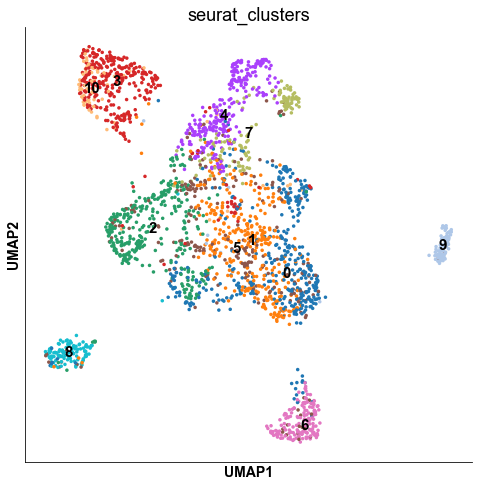

In [207]:
sc.pl.umap(atac_adata, color=['seurat_clusters'], legend_loc='on data')

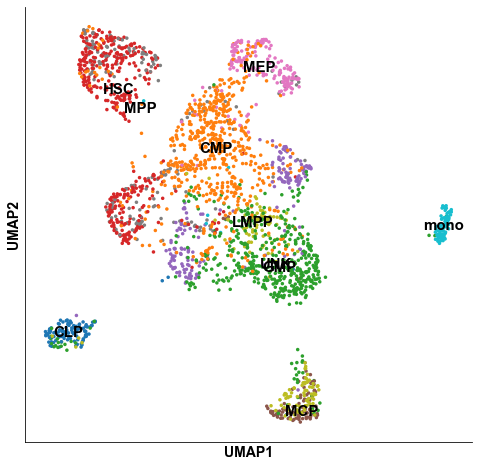

In [208]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(atac_adata, color=['assign.celltype'], legend_loc='on data', title='', ax=ax)
fig.savefig(fname='Figures/S_HSC_ATAC_annotation.pdf', format='pdf')

In [190]:
script_table.loc['singles-BM0828-MEP-160420-22',:].sort_values()

PRMT5    -0.739039
EBNA3    -0.692745
ZNF597   -0.661726
HMG20A   -0.654866
EBNA2    -0.630731
            ...   
RBP2      1.724087
DDX21     1.732321
BCL11A    1.939116
YAP1      2.132992
E2F1      2.299790
Name: singles-BM0828-MEP-160420-22, Length: 1610, dtype: float64

In [199]:
script_table['KMT2A'].sort_values()

singles-PB1022-mono-160128-45                -0.078955
singles-PB1022-mono-160128-9                 -0.077610
singles-160808-scATAC-BM1137-GMP2mid-LS-85   -0.074546
singles-BM0828-MPP-frozen-151103-7           -0.071155
BM1077-LMPP-Frozen-160107-65                 -0.062770
                                                ...   
singles-PB1022-mono-160128-86                 2.873793
singles-PB1022-mono-160128-31                 3.233791
singles-BM0828-CLP-frozen-151103-95           3.550020
singles-PB1022-mono-160128-38                 3.633962
singles-BM0828-MEP-160420-13                  8.669417
Name: KMT2A, Length: 2481, dtype: float64

In [150]:
pd.read_csv('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_peaks_number.txt', sep='\t', header=None)[1].mean()

12373.750503829102

In [3]:
script_adata = sc.read_h5ad('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/SCRIPT_enrichment.h5ad')

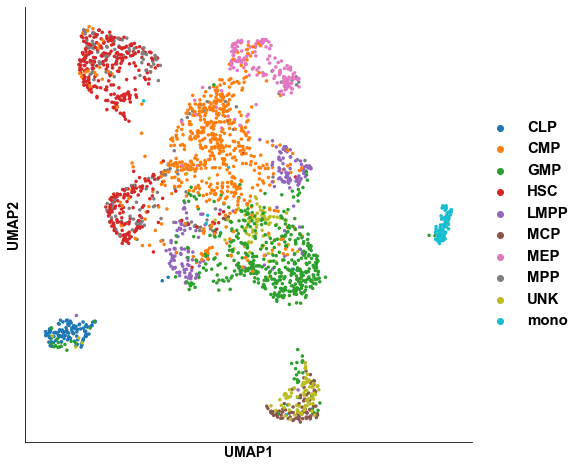

In [126]:
sc.pl.umap(script_adata, color=['assign.celltype'], title='')

In [127]:
fg_dev

,singles-BM0828-CLP-frozen-151103-13,singles-BM0828-LMPP-frozen-151105-40,singles-BM0828-MPP-frozen-151103-43,singles-BM0828-HSC-fresh-151027-37,singles-BM0828-MPP-frozen-151103-60,singles-BM0828-GMP-151027-11,singles-BM0828-MPP-frozen-151103-8,singles-MEP-141017-52,singles-BM0828-CMP-frozen-151118-66,singles-BM0828-CMP-frozen-151118-49,...,singles-160818-BM1137-pDC-LS-59,singles-160819-BM1137-CMP-LS-21,singles-160822-BM1137-CMP-LS-15,singles-160822-BM1137-CMP-LS-62,singles-160822-BM1137-CMP-LS-96,singles-160822-BM1137-CMP-LS-11,singles-160818-BM1137-pDC-LS-70,singles-160822-BM1137-CMP-LS-58,singles-160822-BM1137-CMP-LS-86,singles-160822-BM1137-CMP-LS-95
id,,,,,,,,,,,,,,,,,,,,,
1006_EOMES,-0.470747,0.455518,-0.230407,0.262952,-0.061460,1.385239,-0.605739,5.589381,0.380730,3.565537,...,0.142792,2.249356,-0.216817,-0.576990,0.529862,4.044894,-0.419554,3.630986,-0.030946,1.615050
1007_EP300,1.043498,-0.361251,0.932295,-0.446663,0.312180,-0.127856,-0.546252,-0.590458,0.401364,1.287351,...,-0.740167,0.115459,0.579443,-0.987422,-0.470141,-0.103841,0.017203,0.210188,-0.791176,-0.544368
1010_FOXH1,1.581857,0.961702,-0.019889,1.285269,0.430426,2.814628,-0.209517,6.234820,1.473751,3.428930,...,-0.254220,3.035021,2.442591,-0.533232,-0.430187,4.804698,1.263240,2.054662,1.148370,1.047972
1011_FOXH1,1.603337,-0.262982,0.187898,-0.302247,0.014396,0.115294,-0.717802,-0.265609,0.693882,1.556506,...,-0.510949,0.341644,0.724765,-1.111876,-0.941561,-0.093511,-0.660663,0.370377,-0.655367,-0.395759
1012_FOXP1,0.972165,-0.256958,0.995663,-0.451586,0.045147,-0.265805,-0.481575,-0.599661,0.517037,1.005314,...,-0.755919,0.075253,0.618181,-1.017045,-0.515009,-0.044820,-0.217856,0.112285,-0.784972,-0.435258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509_TFAP2C,1.212754,-0.382887,1.013214,-0.490919,0.114515,-0.097165,-0.455466,-0.538090,0.659591,0.945858,...,-0.732899,-0.006122,0.630246,-1.043933,-0.512161,-0.170035,-0.090888,0.030194,-0.821447,-0.549427
9510_TFAP2C,1.065002,-0.405935,0.773018,-0.477926,0.090479,-0.095068,-0.453188,-0.539950,0.626478,1.107569,...,-0.713463,0.077329,0.638400,-1.069953,-0.499564,-0.127541,-0.038157,0.090146,-0.818153,-0.569656
955_NANOG,2.812136,1.245579,0.908745,1.235649,0.741488,1.074256,-0.622097,0.258947,1.382423,2.303116,...,0.010999,1.230295,1.596101,-1.022022,-0.278656,1.035178,-0.275706,1.322945,0.349450,0.807000


In [143]:
def map_factor_on_ChIP(table):
    # map factor by id "_"
    factor_index_list = []
    for i in table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[1])
    table["Factor"] = factor_index_list
    return table.groupby("Factor").max()

In [257]:
dev_table = map_factor_on_ChIP(tmp)

In [258]:
dev_table

,singles-BM0828-CLP-frozen-151103-13,singles-BM0828-LMPP-frozen-151105-40,singles-BM0828-MPP-frozen-151103-43,singles-BM0828-HSC-fresh-151027-37,singles-BM0828-MPP-frozen-151103-60,singles-BM0828-GMP-151027-11,singles-BM0828-MPP-frozen-151103-8,singles-MEP-141017-52,singles-BM0828-CMP-frozen-151118-66,singles-BM0828-CMP-frozen-151118-49,...,singles-160818-BM1137-pDC-LS-59,singles-160819-BM1137-CMP-LS-21,singles-160822-BM1137-CMP-LS-15,singles-160822-BM1137-CMP-LS-62,singles-160822-BM1137-CMP-LS-96,singles-160822-BM1137-CMP-LS-11,singles-160818-BM1137-pDC-LS-70,singles-160822-BM1137-CMP-LS-58,singles-160822-BM1137-CMP-LS-86,singles-160822-BM1137-CMP-LS-95
Factor,,,,,,,,,,,,,,,,,,,,,
ADNP,2.347487e-199,2.455744e-199,2.513920e-199,8.015026e-200,2.440041e-199,2.104542e-199,8.961252e-200,1.360760e-199,1.263553e-199,2.794548e-199,...,1.365412e-199,9.222580e-200,2.027306e-199,5.459764e-200,3.453382e-199,3.050758e-199,1.284431e-199,3.304935e-199,1.579244e-199,3.321793e-199
AEBP2,3.565098e-192,4.378796e-200,2.608073e-199,1.586413e-199,4.826251e-159,1.353764e-199,5.425226e-127,1.681488e-199,2.214483e-199,1.565911e-175,...,1.170499e-199,2.328364e-199,1.090292e-164,2.177635e-97,1.164966e-116,1.844009e-199,4.016579e-133,2.118614e-184,2.523437e-199,1.171739e-199
AFF1,6.640840e-199,1.230064e-198,6.285058e-199,8.012681e-199,7.551659e-199,5.160057e-199,3.121319e-199,9.880921e-199,7.403852e-199,7.321615e-199,...,1.155994e-198,1.246523e-198,1.423838e-198,4.837241e-199,5.098256e-199,7.743069e-199,3.625691e-199,5.649502e-199,1.506854e-198,2.398840e-198
AFF4,8.233491e-199,1.804532e-198,2.067663e-198,1.771556e-198,1.704559e-163,8.361444e-199,7.731732e-137,7.773853e-199,1.257865e-198,7.900588e-199,...,1.532685e-198,1.229025e-198,1.695801e-198,9.451872e-134,5.582594e-185,1.660053e-198,4.183368e-163,1.341796e-198,1.337432e-198,8.690477e-199
AGO1,3.479056e-199,4.800912e-199,8.041405e-163,3.042582e-199,4.958636e-133,1.182238e-199,7.876465e-132,1.029567e-199,3.113894e-199,4.771363e-186,...,2.820093e-199,2.338493e-199,1.391884e-186,1.969474e-83,8.763548e-80,1.998817e-199,6.718027e-121,4.558950e-173,1.876723e-199,1.443192e-199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN5A,2.625094e-46,1.860826e-93,2.640889e-40,2.792585e-86,7.967262e-25,2.949869e-68,4.707740e-26,9.130892e-49,2.581125e-64,2.653224e-44,...,2.357060e-49,5.606210e-63,8.332595e-45,2.155453e-17,2.523746e-50,1.289722e-82,8.723943e-33,3.041694e-59,1.208097e-67,6.828347e-88
ZTA,3.774271e-05,1.473756e-11,2.019036e-07,6.858741e-06,1.825188e-03,8.298913e-15,8.280589e-03,7.202881e-05,2.000963e-08,3.412272e-03,...,1.183354e-10,3.199105e-11,7.485086e-11,3.169341e-06,8.358793e-07,1.640064e-15,3.030074e-06,1.907052e-08,2.713840e-25,4.143663e-14
ZXDB,3.919136e-199,7.188700e-199,7.786009e-199,6.159334e-199,8.459077e-199,2.596734e-199,4.596555e-199,3.685662e-199,6.211659e-199,3.704403e-199,...,3.117115e-199,9.538356e-199,9.182650e-199,5.404078e-199,5.020617e-199,2.436497e-199,4.036317e-199,3.019296e-199,7.822267e-199,3.672950e-199


In [182]:
dev_table.max(1).sort_values()[0:800].index

Index(['PRMT5', 'BRD7', 'UBE2I', 'ZNF35', 'ZKSCAN5', 'INTS12', 'FEZF1',
       'FOXG1', 'ZNF189', 'ZNF362',
       ...
       'FOXO3', 'PTTG1', 'ARID1A', 'ZNF207', 'SMARCE1', 'ZNF490', 'MTOR',
       'ZNF627', 'PRDM12', 'SMAD4'],
      dtype='object', name='Factor', length=800)

In [148]:
script_adata.obs = pd.concat([script_adata.obs.iloc[:,0:7], dev_table.T.reindex(index=script_adata.obs.index)],1)

In [260]:
script_adata

AnnData object with n_obs × n_vars = 2429 × 292394
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'ATAC_snn_res.0.6', 'seurat_clusters', 'ident', 'assign.celltype', 'ADNP', 'AEBP2', 'AFF1', 'AFF4', 'AGO1', 'AGO2', 'AHR', 'AHRR', 'APOBEC3B', 'AR', 'ARID1A', 'ARID2', 'ARID3A', 'ARID5B', 'ARNT', 'ARNT2', 'ARNTL', 'ARRB1', 'ASCL1', 'ASCL2', 'ASH1L', 'ASH2L', 'ASXL1', 'ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'ATF7IP', 'ATOH1', 'AUTS2', 'BACH1', 'BACH2', 'BAHD1', 'BANF1', 'BANP', 'BARX1', 'BARX2', 'BATF', 'BATF3', 'BCAT1', 'BCL11A', 'BCL11B', 'BCL3', 'BCL6', 'BCLAF1', 'BCOR', 'BHLHE40', 'BIRA', 'BMI1', 'BPTF', 'BRAF', 'BRCA1', 'BRD1', 'BRD2', 'BRD3', 'BRD4', 'BRD7', 'BRD9', 'BRDU', 'BRPF3', 'BTAF1', 'C11orf30', 'C17orf49', 'C17orf96', 'CAMTA2', 'CASP8AP2', 'CBFA2T2', 'CBFB', 'CBX1', 'CBX2', 'CBX3', 'CBX4', 'CBX5', 'CBX6', 'CBX7', 'CBX8', 'CCDC101', 'CCND2', 'CCNT2', 'CD59', 'CD74', 'CDC5L', 'CDCA2', 'CDK12', 'CDK2', 'CDK6', 'CDK7', 'CDK8', 'CDK9', 'CDX2', 'CEBPA', 'CEBPB', 'CEBPD', 'C

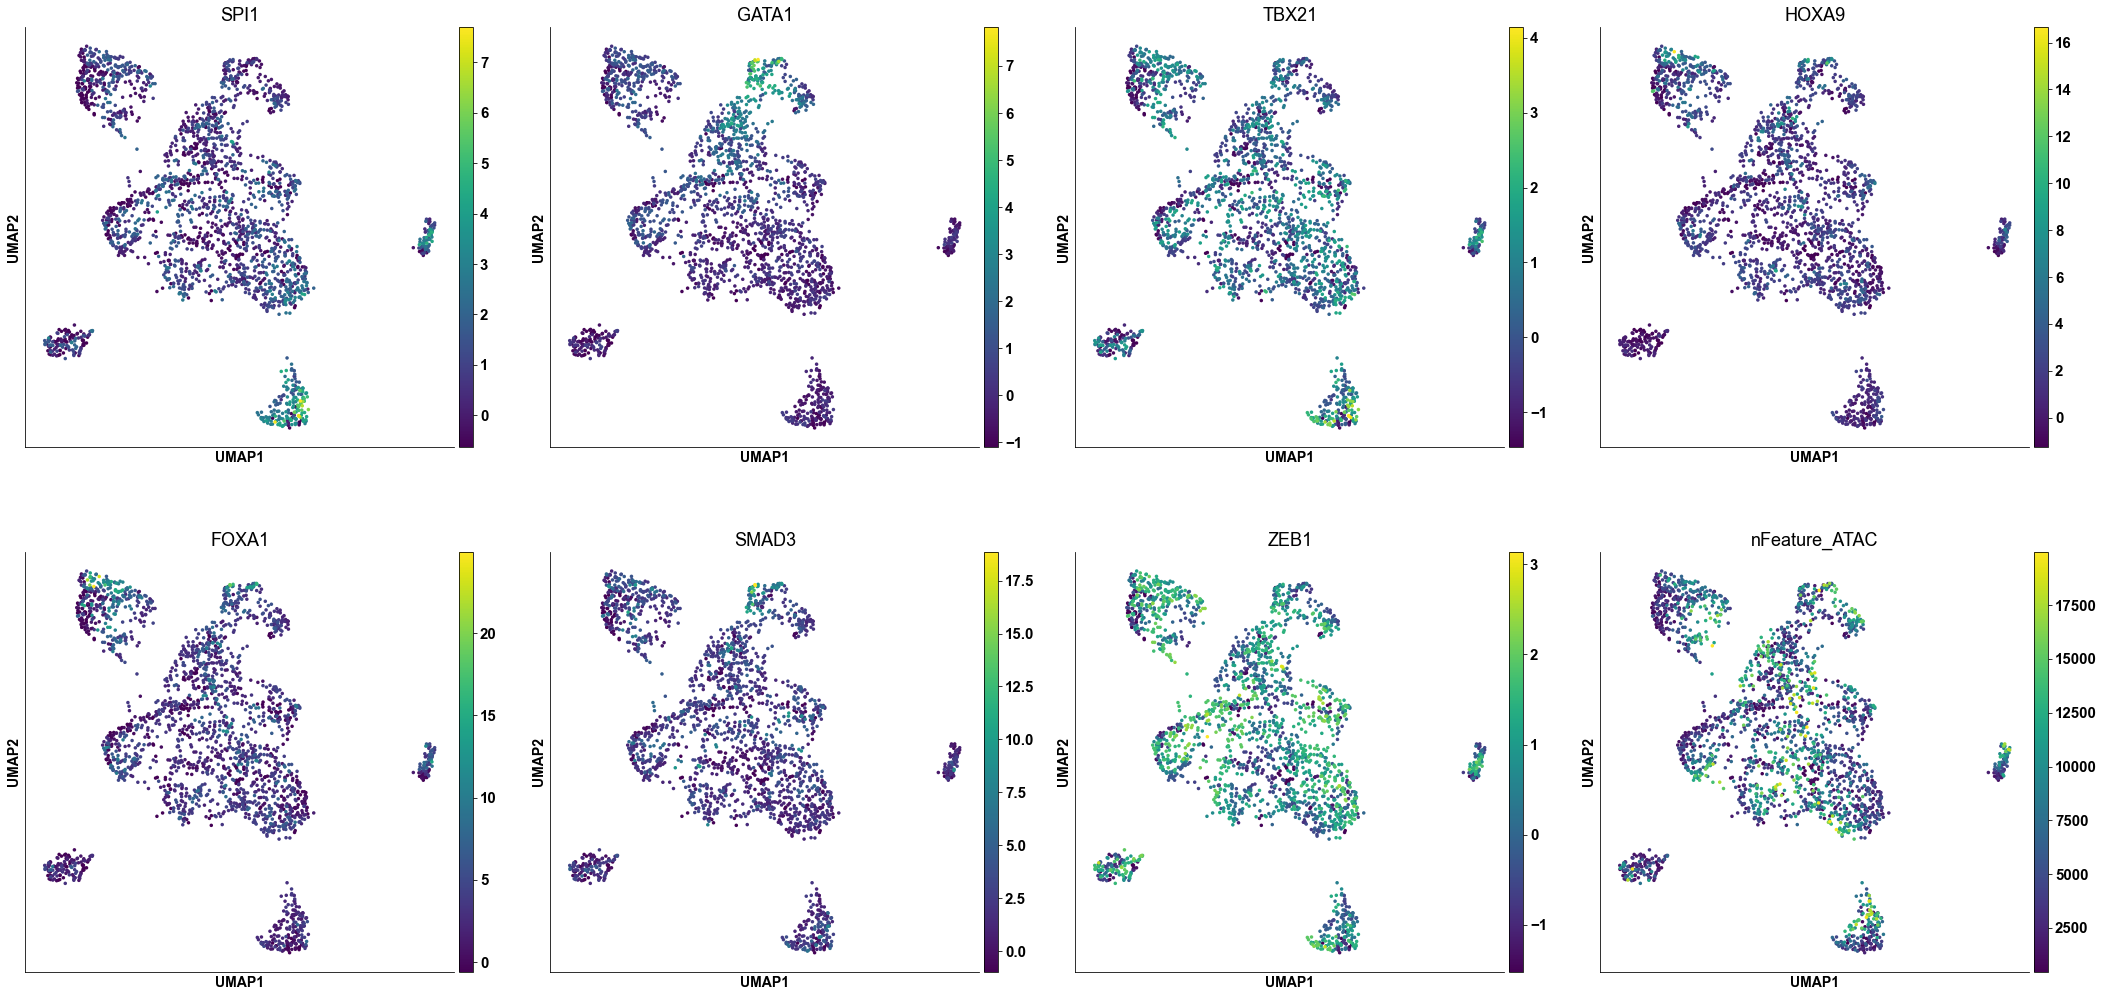

In [261]:
sc.pl.umap(script_adata, color=['SPI1','GATA1','TBX21', 'HOXA9','FOXA1','SMAD3','ZEB1','nFeature_ATAC'])

In [8]:
script_table = script_adata.uns['integrated'].copy()

In [ ]:
script_table

In [218]:
script_table.columns=[i[2:] for i in script_table.columns]

In [157]:
script_table.to_csv('example/small_HSC/script_pseudotime/score.txt', sep='\t')

In [158]:
script_adata.obs.iloc[:, 0:7].reindex(index=script_table.index).to_csv('example/small_HSC/script_pseudotime/meta_data.txt', sep='\t')

In [159]:
pd.DataFrame(script_table.index).to_csv('example/small_HSC/script_pseudotime/feature.txt', sep='\t', header=None, index=None)

In [122]:
script_table.std().sort_values()[-1000:].index

Index(['I_SALL4', 'I_SPIC', 'I_PAX9', 'I_ZNF383', 'I_SOX10', 'I_ZIM3',
       'I_ZNF530', 'I_ZNF75D', 'I_LOC107197952', 'I_ZNF224',
       ...
       'I_RAD21', 'I_GATA1', 'I_SMARCA4', 'I_CEBPA', 'I_SPI1', 'I_TAL1',
       'I_GATA2', 'I_EP300', 'I_RAG2', 'I_KMT2A'],
      dtype='object', length=1000)

In [ ]:
script_table[script_table.std().sort_values()[-1000:].index]

In [190]:
dev_table.loc[dev_table.max(1).sort_values()[200:700].index,:].T.copy()

Factor,EMSY,MCM3,ZNF654,NR4A1,ZNF600,ADNP,CASP8AP2,CTBP2,ASH1L,RBL2,...,HOXA13,SRCAP,PRPF4,ZNF333,GLYR1,FOSL2,ZNF267,IRF1,ZNF438,JUNB
singles-BM0828-CLP-frozen-151103-13,0.655676,0.545438,-0.019177,0.824396,1.402933,0.623910,0.441208,1.370777,1.123661,0.920482,...,0.533108,2.567212,0.997587,1.865203,0.353478,0.347483,1.306503,2.414568,1.043136,0.655851
singles-BM0828-LMPP-frozen-151105-40,-0.467817,-0.721732,-0.290713,-0.327729,-0.187552,-0.491811,-0.854382,-0.229149,-0.617038,-0.461868,...,-0.028272,0.731583,-0.059245,0.032591,0.044605,-0.470748,-0.581094,0.015680,0.566683,-0.367035
singles-BM0828-MPP-frozen-151103-43,2.083866,2.083680,0.999436,1.204420,0.761861,1.381988,2.045849,1.578126,1.312255,2.251900,...,2.101867,1.483305,2.377351,1.397809,1.533765,0.330133,0.942479,1.369490,1.508516,1.663505
singles-BM0828-HSC-fresh-151027-37,-0.721994,-0.841692,-0.231414,-0.207318,-0.296917,-0.535325,-0.961113,-0.370383,-0.804390,-0.610985,...,-0.241075,0.123679,-0.063544,-0.066216,1.202747,-0.423446,-0.362858,0.222170,-0.466831,-0.292621
singles-BM0828-MPP-frozen-151103-60,1.217697,1.467435,0.081060,0.330093,0.277647,0.240146,1.467883,1.605204,1.458098,1.553300,...,0.664045,-0.166087,0.160504,0.701005,1.052700,-0.113336,1.261037,1.382518,0.417545,1.673311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
singles-160822-BM1137-CMP-LS-11,-0.323572,-0.329033,0.228938,0.108997,-0.120861,0.236618,-0.615651,-0.082966,-0.617443,-0.335601,...,0.273677,0.262728,0.398105,-0.190332,1.268773,0.032554,0.501101,0.063623,0.377843,0.172206
singles-160818-BM1137-pDC-LS-70,1.140146,1.285137,-0.599918,0.306990,-0.131997,-0.030310,1.458038,1.211274,0.605889,1.267585,...,1.070596,-0.419851,0.470796,-0.878439,0.934350,0.668126,0.271902,0.970679,0.219473,1.614792
singles-160822-BM1137-CMP-LS-58,-0.427599,-0.213418,0.611932,0.559075,0.084291,0.362284,-0.627839,0.170691,-0.454087,-0.228273,...,-0.664283,0.406307,0.628388,-0.494649,1.807274,0.730201,0.488291,0.171891,0.155320,0.604634
singles-160822-BM1137-CMP-LS-86,-1.021692,-1.084846,-0.745458,-0.702928,-0.769945,-0.777325,-1.278568,-0.827405,-1.298738,-0.979399,...,-0.686286,-0.445556,-0.596966,-0.684153,-0.499791,-0.283481,-0.774054,-0.731487,-0.224871,-0.431766


In [204]:
from sklearn.cluster import KMeans
import numpy as np

In [249]:
tmp = dev_table[dev_table.max().sort_values()[0:-300].index]

In [250]:
kmeans_factor = KMeans(n_clusters=7, random_state=0).fit(tmp)
kmeans_cell = KMeans(n_clusters=7, random_state=0).fit(tmp.T)
# kmeans.labels_

In [251]:
factor_idx = []
cell_idx = []
for k in range(0,7):
    for i,j in enumerate(kmeans_factor.labels_):
        if j == k:
            factor_idx.append(i)
    for i,j in enumerate(kmeans_cell.labels_):
        if j == k:
            cell_idx.append(i)

<AxesSubplot:ylabel='Factor'>

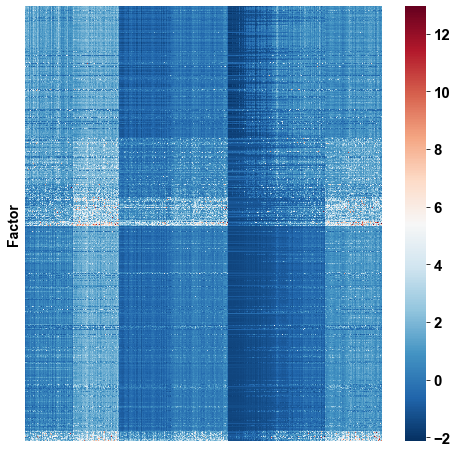

In [252]:
sns.heatmap(tmp.iloc[factor_idx,cell_idx], xticklabels=False,  yticklabels=False, cmap='RdBu_r')

In [254]:
for i in tmp.iloc[factor_idx,cell_idx].index:
    print(i)

AEBP2
AFF1
AFF4
ARNT2
ARNTL
ASCL2
ASH1L
ATF1
ATF2
ATF5
ATF7IP
ATOH1
AUTS2
BACH2
BANP
BARX1
BARX2
BCAT1
BCL11B
BCL3
BHLHE40
BRAF
BRCA1
BRD1
BRD2
BTAF1
CASP8AP2
CBFA2T2
CBX4
CBX6
CCDC101
CCND2
CD59
CD74
CDC5L
CEBPZ
CHAT
CHD1
CHD7
CIITA
CLOCK
CPSF3L
CREB1
CREB3
CREB3L4
CREM
CTBP2
DCP1A
DDX21
DEAF1
DNMT3A
DPF1
DR1
DROSHA
DYRK1A
E2F1
E2F4
EGR1
EGR2
EHF
EHMT2
ELF1
ELF2
ELF5
ELK1
ELK4
ELL2
EMSY
EPC1
ERF
ETS1
ETS2
EZH1
FAIRE
FEV
FOXG1
FOXK2
FOXP3
FXR1
GABPA
GAPDH
GATAD2B
GLIS1
GMEB1
GMEB2
GRHL1
GRP20
GTF2A2
GTF2B
GTF3C5
GUCY1B3
H2AZ
HAND1
HBP1
HCFC1
HDAC6
HDGF
HECTD1
HEYL
HIF1A
HINFP
HJURP
HNRNPLL
HOXA1
HOXA13
ICE2
INO80
IRAK4
IRF3
JMJD6
KAT2B
KAT5
KAT8
KDM1B
KDM2B
KDM3A
KDM3B
KDM4B
KDM5A
KDM5C
KDM6B
KLF1
KLF10
KLF12
KLF3
KLF4
KLF5
KLF9
KMT2D
KRAB
LANA
LIN9
LRWD1
MAFB
MAX
MCM3
MCRS1
MKL1
MORC2
MPHOSPH8
MTA3
MXD3
MYBL2
MYCN
NBN
NELFE
NFAT5
NFYA
NKX2-2
NME2
NONO
NR0B1
NR2C2
NRF1
NUP153
NUP98
OGT
ORC1
OVOL2
PAF1
PARP1
PBX1
PBX2
PCGF1
PHF6
PHF8
POLR2M
POLR3A
POU2F1
POU3F2
PPARD
PPARGC1A
PRKDC
PRMT

In [253]:
for i in tmp.iloc[factor_idx,cell_idx].columns:
    print(i)

singles-20160617-scATAC-BM1214-CMP-LS-50
singles-BM1214-GMP-160421-89
singles-PB1022-mono-160128-62
singles-PB1022-mono-160128-95
singles-20160726-scATAC-BM1214-CMP-LS-36
singles-BM0828-HSC-fresh-151027-12
singles-160808-scATAC-BM1137-GMP2mid-LS-76
singles-PB1022-mono-160128-64
singles-PB1022-mono-160128-46
singles-BM0828-MPP-frozen-151103-17
singles-BM0828-MPP-frozen-151103-19
singles-BM0828-HSC-frozen-151027-78
singles-BM0106-UNK-160418-92
singles-BM1214-GMP-160421-52
singles-BM0828-HSC-frozen-151027-69
singles-BM0828-HSC-frozen-151027-50
singles-MEP-141017-88
singles-BM0828-MEP-160420-9
singles-BM0828-CLP-frozen-151103-57
singles-BM0828-CLP-frozen-151103-65
singles-20160617-scATAC-BM1214-CMP-LS-43
singles-160809-scATAC-BM1137-GMP1low-LS-33
BM1077-LMPP-Frozen-160107-4
singles-BM0106-UNK-160418-81
singles-BM1214-GMP-160421-50
singles-BM0828-GMP-151027-56
singles-BM1214-GMP-160421-66
BM1077-CLP-Frozen-160106-96
singles-20160617-scATAC-BM1077-CMP-HYC-5
singles-BM0828-GMP-151027-35
singl

In [224]:
dev_table.max().sort_values()[0:-20].index

Index(['singles-160819-BM1137-CMP-LS-3',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-91',
       'BM1077-LMPP-Frozen-160107-34', 'BM1077-LMPP-Frozen-160107-22',
       'singles-BM1214-MCP-frozen-160128-72',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-34',
       'singles-160822-BM1137-CMP-LS-80',
       'singles-BM0828-HSC-frozen-151027-80', 'singles-BM0828-GMP-151027-37',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-10',
       ...
       'singles-20160726-scATAC-BM1214-CMP-LS-88',
       'singles-20160726-scATAC-BM1214-CMP-LS-2',
       'singles-BM0106-HSC-LS-160219-23',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-19',
       'singles-BM0828-CLP-frozen-151103-75', 'BM1077-CLP-Frozen-160106-93',
       'singles-BM0828-CMP-frozen-151118-68',
       'singles-BM0828-MPP-frozen-151103-81',
       'singles-BM0106-HSC-SIM-160219-84', 'BM1077-HSC-Frozen-160105-26'],
      dtype='object', length=2409)

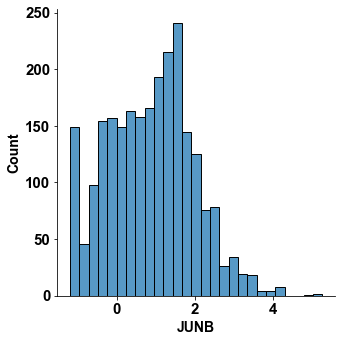

In [197]:
sns.displot(dev_table.loc['JUNB',:])

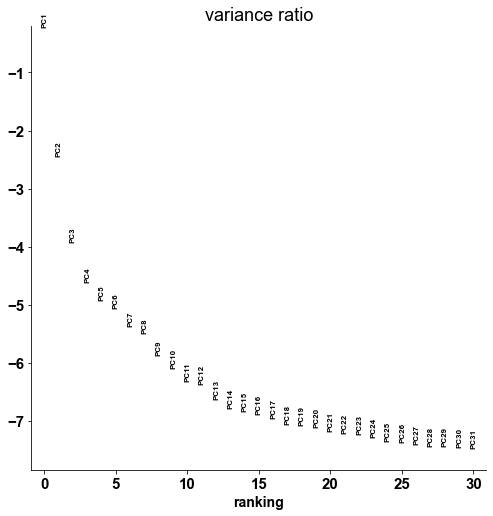

In [188]:
script_table_final = dev_table.loc[dev_table.max(1).sort_values()[200:700].index,:].T.copy()
# script_table.columns=[i[2:] for i in script_table.columns]
# script_table = script_table.dropna(axis=1,how='any')
sudo_expression_SCRIPT = ad.AnnData(script_table_final)
sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=30)
sc.tl.umap(sudo_expression_SCRIPT)
sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
sudo_expression_SCRIPT.obs['real_cell_type']=script_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

In [264]:
sudo_expression_SCRIPT.obs['nFeature_ATAC']=script_adata.obs['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]

In [ ]:
help(sc.pp.neighbors)

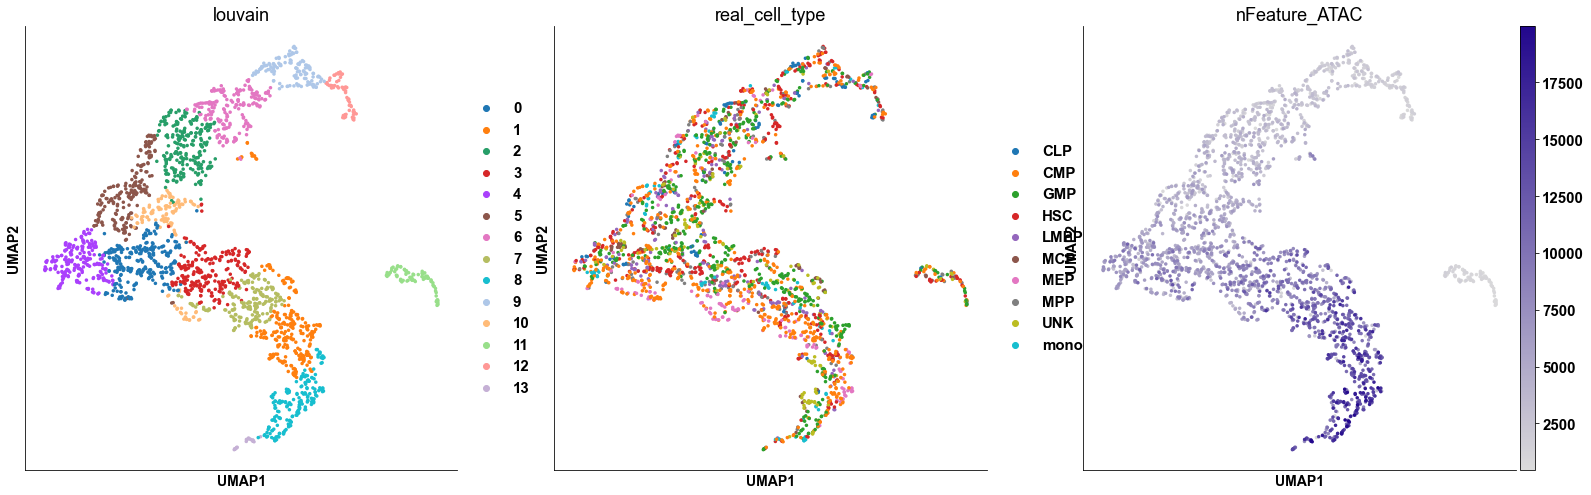

In [265]:
sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type','nFeature_ATAC'], color_map=regulation_cmp)

In [263]:
sudo_expression_SCRIPT

AnnData object with n_obs × n_vars = 2429 × 500
    obs: 'louvain', 'real_cell_type'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'real_cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [169]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['real_cell_type'], sudo_expression_SCRIPT.obs['louvain'])

0.09870513154670515

In [92]:
chromVAR_table = pd.read_csv('example/small_HSC/chromvar_result.txt', sep='\t')

In [93]:
chromVAR_table

,singles-BM0828-HSC-fresh-151027-1,singles-BM0828-HSC-fresh-151027-2,singles-BM0828-HSC-fresh-151027-3,singles-BM0828-HSC-fresh-151027-4,singles-BM0828-HSC-fresh-151027-5,singles-BM0828-HSC-fresh-151027-6,singles-BM0828-HSC-fresh-151027-7,singles-BM0828-HSC-fresh-151027-9,singles-BM0828-HSC-fresh-151027-10,singles-BM0828-HSC-fresh-151027-11,...,singles-160822-BM1137-CMP-LS-86,singles-160822-BM1137-CMP-LS-87,singles-160822-BM1137-CMP-LS-88,singles-160822-BM1137-CMP-LS-89,singles-160822-BM1137-CMP-LS-91,singles-160822-BM1137-CMP-LS-92,singles-160822-BM1137-CMP-LS-93,singles-160822-BM1137-CMP-LS-94,singles-160822-BM1137-CMP-LS-95,singles-160822-BM1137-CMP-LS-96
TFAP2B,-0.397524,0.005783,-0.788596,-1.083218,1.825802,0.487675,-0.272586,-0.500205,-0.716712,-0.534709,...,0.958785,-0.604309,1.230666,0.540739,-1.789948,-1.613672,-1.231017,-1.712968,-1.567738,0.349952
TFAP2D,-0.356856,0.092021,-0.094158,0.514756,0.263169,0.015021,-0.617082,-0.324045,-0.269767,0.730894,...,-1.645474,1.363402,0.669402,-1.200121,-0.672807,0.712106,-0.492168,0.524516,0.584399,0.441165
TFAP2C,-1.198091,0.343878,-1.637094,-0.088768,0.063501,-0.444099,-1.373796,-0.583475,-1.021473,0.521197,...,-0.902658,-1.544094,0.911395,-0.338266,-0.176943,-1.475680,1.596190,-0.354391,-0.896831,0.464957
TFAP2E,1.768464,0.202474,-0.317446,1.293349,-0.473619,0.185660,-1.261914,-1.975971,1.042417,-0.925022,...,-0.419001,0.198164,0.247822,-0.228694,-0.452832,-0.683629,1.379803,0.566493,0.129517,0.286090
TFAP2A,0.549738,-0.114103,0.353257,-1.957392,0.477793,0.856567,-1.948007,-0.259364,0.588405,-2.346092,...,0.295498,-1.043828,-1.015145,0.439106,0.127937,-1.495369,0.455565,0.568552,-0.470598,-0.995118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD5,-0.628652,-0.655992,0.713102,0.400979,0.644434,-0.052022,0.412039,0.252212,1.202150,-0.222288,...,-2.420264,0.662608,-0.376090,-1.589566,1.112782,2.157339,0.282884,0.229983,0.422254,-0.406279
SMAD9,-0.828333,-0.877532,-0.802282,-1.949369,-0.946353,-1.122996,0.369391,-1.060979,-1.852575,-0.279622,...,4.873191,0.518892,1.159851,0.438550,-2.146915,-1.542454,1.197853,0.141055,-1.076484,-1.676307
SOX6,0.327787,-1.384739,-0.559125,-0.356809,-0.540549,0.383801,-0.909244,1.652291,-0.141277,-0.905906,...,-0.093080,-1.554633,-0.553731,-0.775189,0.689327,-0.001561,0.106326,0.453900,0.503147,1.378253
TBX18,1.183752,-0.423629,-0.521903,0.124339,-1.514624,0.770501,1.220335,-1.118830,1.216039,-0.144517,...,0.753774,0.646812,-0.465764,0.368918,-0.462981,-2.308783,2.656637,-1.539652,-0.195305,-0.573801


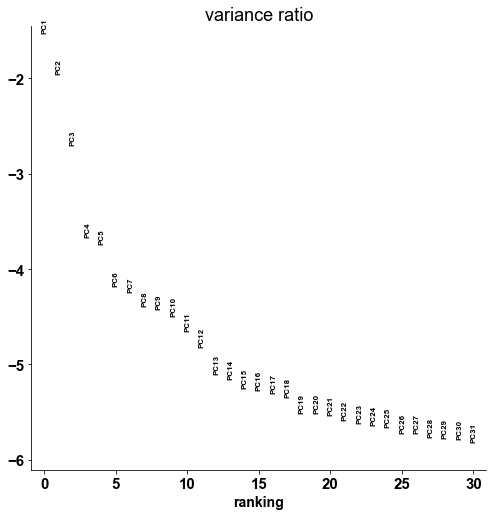

In [101]:
sudo_expression_chromvar= ad.AnnData(chromVAR_table.T)
sc.tl.pca(sudo_expression_chromvar, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromvar, log=True)
sc.pp.neighbors(sudo_expression_chromvar, n_neighbors=10, n_pcs=30)
sc.tl.umap(sudo_expression_chromvar)
sc.tl.louvain(sudo_expression_chromvar, resolution=0.6)
sudo_expression_chromvar.obs['real_cell_type']=atac_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

... storing 'real_cell_type' as categorical


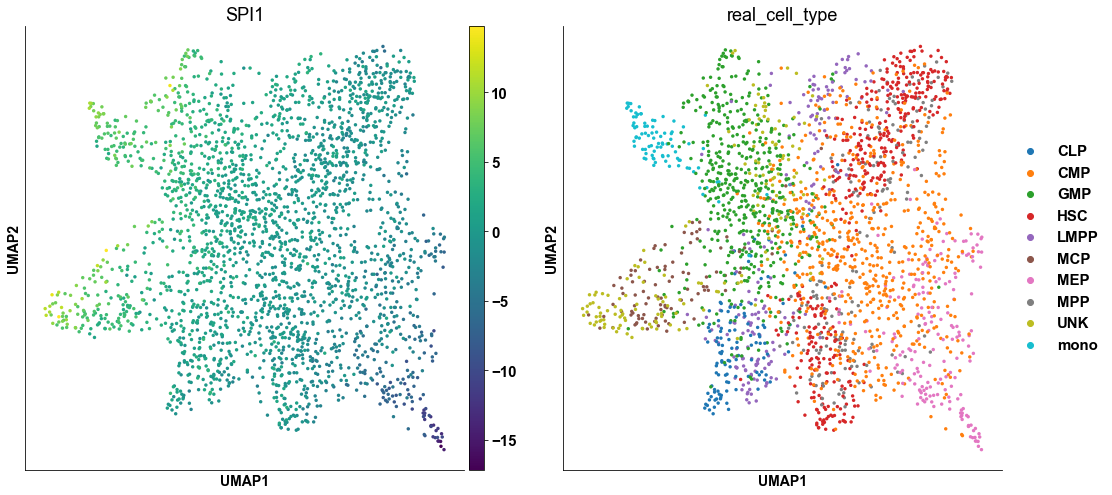

In [212]:
sc.pl.umap(sudo_expression_chromvar, color=['SPI1','real_cell_type'])

In [176]:
sudo_expression_chromvar.obs['real_cell_type'] = [i.split('-')[0] for i in index_list]

In [ ]:
sudo_expression_chromvar.obs

In [210]:
sklearn.metrics.normalized_mutual_info_score(atac_adata.obs['seurat_clusters'], atac_adata.obs['assign.celltype'])

0.4406487678538429

In [201]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type'])

0.22220002921224424

In [202]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_chromvar.obs['louvain'], sudo_expression_chromvar.obs['real_cell_type'])

0.44462259902750206

In [296]:
bg_dataset_odds_ratio_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_odds_ratio_df_ChIP.pk')

In [66]:
fg_dataset_deviation_df_motif = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_deviation_df_motif.pk')

In [85]:
tmp = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_deviation_df_ChIP.pk')

In [79]:
bc = [i for i in tmp.index if i.endswith('KMT2A')]

In [87]:
tmp.loc[bc,'singles-BM0828-MEP-160420-1'].sort_values()

id
73847_KMT2A      0.320062
34962_KMT2A      0.468201
73708_KMT2A      1.379662
73707_KMT2A      1.791905
73716_KMT2A      3.328281
77486_KMT2A      4.144228
73715_KMT2A    146.285509
Name: singles-BM0828-MEP-160420-1, dtype: float64

In [572]:
tmp = {}
for i in rna_adata.obs['assign.ident'].cat.categories:
    locals()['%s_bc' % i] = rna_adata.obs['assign.ident'][rna_adata.obs['assign.ident'] == i].index.tolist()
    locals()['%s_expr' % i] = pbmc_expr.loc[locals()['%s_bc' % i],:].mean()
    tmp[i] = locals()['%s_expr' % i]

celltype_expr = pd.DataFrame(tmp)

In [576]:
celltype_expr.to_csv('example/PBMC/cluster_expr.txt', sep='\t')

# Plot

In [ ]:
chromVAR_table.T

In [ ]:
expression = pd.read_csv('example/PBMC/cluster_expr.txt', sep='\t', index_col=0)
# expression = np.log(expression + 0.00001)

chromVAR_table = pd.read_csv('example/PBMC/chromVAR_ztable.txt', sep='\t').T

# pbmc_script_adata = ad.read_h5ad('example/PBMC/multiome_pbmc_SCRIPT/enrichment/SCRIPT_enrichment.h5ad')

script_table = pbmc_script_adata.uns['integrated_z']

metadata = atac_adata.obs

In [ ]:
script_table

In [ ]:
atac_adata

### SCRIPT chromVAR Expression

In [ ]:
chromVAR_dict = {}
SCRIPT_dict = {}
for i in expression.columns:
    locals()[i+'_cells'] = metadata[(metadata['assign.celltype'] == i)].index
    locals()[i] = chromVAR_table.loc[locals()[i+'_cells'],].mean()
    chromVAR_dict[i] = locals()[i]
    locals()[i] = script_table.loc[locals()[i+'_cells'],].mean()
    SCRIPT_dict[i] = locals()[i]

In [ ]:
SCRIPT_table = pd.DataFrame(SCRIPT_dict)
chromVAR_table = pd.DataFrame(chromVAR_dict)

In [ ]:
SCRIPT_table.index = [i[2:] for i in SCRIPT_table.index]

In [ ]:
SCRIPT_table = SCRIPT_table.drop(['CPEB1','ZNF354C'])

In [ ]:
sc_ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()))
ch_ovlp_factor = list(set(chromVAR_table.index.to_list())  & set(expression.index.to_list()))

In [ ]:
ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()) & set(chromVAR_table.index.to_list()))

In [ ]:
ovlp_factor

In [ ]:
for i in expression.columns:
    expression_sub = expression.loc[ovlp_factor, i]
    chromVAR_sub = chromVAR_table.loc[ovlp_factor, i]
    SCRIPT_sub = SCRIPT_table.loc[ovlp_factor, i]
    locals()[i+'_table'] = pd.DataFrame({'expression':expression_sub, 'chromVAR':chromVAR_sub, 'SCRIPT':SCRIPT_sub})

In [ ]:
MonoMac_table

In [ ]:
MonoMac_table[MonoMac_table['SCRIPT'] > 4]

In [ ]:
expression.columns

In [ ]:
cell = 'TProliferation'
data = locals()[cell + "_table"]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x='chromVAR', y='SCRIPT', hue='expression', palette='RdBu_r', ax=ax, legend=False)
ax.set_title('%s Cell' % cell)
texts = []
for i in range(len(data.index)):
    if abs(data.iloc[i,1]) > 1:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
    if abs(data.iloc[i,2]) > 1.3:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))
fig.show()

### Recall ratio

In [ ]:
with open('TF_names_v_1.01.txt', 'r') as file_handle:    
    TF_list = [i.rstrip('\n') for i in file_handle.readlines()]

In [ ]:
tf_ovlp_factor = list(set(TF_list) & set(expression.index))

In [ ]:
script_motif_table = pbmc_script_adata.uns['motif_z'].copy()

script_ChIP_table = pbmc_script_adata.uns['ChIP_z'].copy()

script_table = pbmc_script_adata.uns['integrated_z'].copy()
script_table.columns=[i[2:] for i in script_table.columns]
# script_table = script_table.drop(['CPEB1', 'ZNF354C'], axis=1)

In [ ]:
ovlp_factor = set(expression.index) & set(script_table.columns) & set(chromVAR_table.columns) & set(script_ChIP_table.columns) & set(script_motif_table.columns)

In [ ]:
ch_ovlp_factor = set(expression.index) & set(chromVAR_table.columns)
sc_ovlp_factor = set(expression.index) & set(script_table.columns)
sc_chip_ovlp_factor = set(expression.index) & set(script_ChIP_table.columns)
sc_motif_ovlp_factor = set(expression.index) & set(script_motif_table.columns)

In [ ]:
ovlp_factor.__len__()

In [ ]:
expression

In [ ]:
chromVAR_table

In [ ]:
chromVAR_table.loc[cell_bc, ch_ovlp_factor]

In [ ]:
result = {}
for cell in expression.columns:
#     expression100 = set(expression.loc[ovlp_factor,cell].sort_values(ascending=False)[0:50].index)
    expression100 = set(expression[expression[cell]>np.median(expression[cell])].index)
    cell_bc = metadata[(metadata['assign.celltype'] == cell)].index
    chromvar_cell_bc = set(cell_bc) & set(chromVAR_table.index)
    chromvar100 = set(chromVAR_table.loc[chromvar_cell_bc, ch_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script100 = set(script_table.loc[cell_bc, sc_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_motif_100 = set(script_motif_table.loc[cell_bc, sc_motif_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_chip_100 = set(script_ChIP_table.loc[cell_bc, sc_chip_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    c_tp = expression100.intersection(chromvar100).__len__()
    c_fn = (expression100 - chromvar100).__len__()
#     c_pre = c_tp/(c_tp+)
    c_recall = c_tp/100
    
    result[cell] = {'chromvar':expression100.intersection(chromvar100).__len__(),
                    'script_integrate':expression100.intersection(script100).__len__(),
                   'script_motif (not full)':expression100.intersection(script_motif_100).__len__(),
                   'script_ChIP':expression100.intersection(script_chip_100).__len__(),}
#                     'consistant':chromvar100.intersection(script100).__len__()}
result = pd.DataFrame(result)

data = (result/100).T.melt()

data['type'] = list(result.columns)*4

In [ ]:
data

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data=data, x="type", y="value", hue="variable")
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_xlabel('Cell Type')
ax.set_ylabel('Recall Rate')
ax.set_title('Expressed Factors in expression')
fig.show()

### NMI

In [ ]:
# filter bad bed files
bed_peak_number = pd.read_csv('/mnt/Storage/home/dongxin/Projects/scATAC/human/peak_number.txt', sep=' ', header = None)

In [ ]:
bad_factor = set([i.split('_')[1].split('.')[0] for i in bed_peak_number[bed_peak_number.iloc[:,1] < 3000][0]])

In [ ]:
good_factor = set(script_table.columns) - bad_factor

In [ ]:
sns.distplot(chromVAR_table_file['TCF7'])

In [ ]:
script_table = pbmc_script_adata.uns['ChIP_z']
script_table = script_table.loc[:,good_factor].copy()
sudo_expression_SCRIPT = ad.AnnData(script_table)

In [ ]:
sns.displot(script_table['EOMES'])

In [ ]:
script_table = script_table.replace([np.inf, -np.inf], np.nan)
script_table = script_table.dropna(axis=1,how='any')

In [ ]:
script_table.columns = [i[2:] for i in script_table.columns]

In [ ]:
for i in script_table.index:
    print(i + '\t' + str(np.std(script_table.loc[i,])))

In [ ]:
script_table

In [ ]:
sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_SCRIPT)
sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)

sudo_expression_SCRIPT.obs['RNA_cluster']=pbmc_script_adata.obs['seurat_clusters'][sudo_expression_SCRIPT.obs.index]
sudo_expression_SCRIPT.obs['RNA_cell_type']=pbmc_script_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color=['louvain', 'RNA_cluster','RNA_cell_type'])

In [ ]:
chromVAR_table = pd.read_csv('example/10X_ATAC/chromVar_result_table.txt', sep='\t')
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

In [ ]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.6)

sudo_expression_chromVAR.obs['RNA_cluster']=pbmc_script_adata.obs['seurat_clusters'][sudo_expression_chromVAR.obs.index]
sudo_expression_chromVAR.obs['RNA_cell_type']=pbmc_script_adata.obs['assign.celltype'][sudo_expression_chromVAR.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color=['louvain', 'RNA_cluster','RNA_cell_type'])

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='louvain')

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='TBX21')

In [ ]:
chromVAR_table_file = pd.read_csv('example/10X_ATAC/chromVAR_z_table.txt', sep='\t')

In [ ]:
chromVAR_table = chromVAR_table_file.replace([np.inf, -np.inf], np.nan)
chromVAR_table = chromVAR_table.dropna(axis=1,how='any')

In [ ]:
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

In [ ]:
sudo_expression_chromVAR

In [ ]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)

In [ ]:
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.8)

In [ ]:
sudo_expression_chromVAR.obs['cell_type']=gold_cluster[sudo_expression_chromVAR.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color='louvain')

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color='cell_type')

In [ ]:
gold_cluster = metadata[metadata['tech']=='ATAC']['assign.ident']

In [ ]:
real = gold_cluster[sudo_expression_chromVAR.obs.index]

In [ ]:
script_nmi = sudo_expression_SCRIPT.obs['louvain'][sudo_expression_chromVAR.obs.index]
# chromvar_nmi = sudo_expression_chromVAR.obs['louvain'][sudo_expression_chromVAR.obs.index]

In [ ]:
sklearn.metrics.normalized_mutual_info_score(real, script_nmi)

In [ ]:
sklearn.metrics.normalized_mutual_info_score(real, chromvar_nmi)

In [ ]:
seurat_adata.obs['assign.celltype']=="B"

In [ ]:
inputmat

In [ ]:
inputmat = pbmc_10X_inputMat.to_df()

In [ ]:
B_cluster = inputmat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="B"].index,:]

In [ ]:
B_cluster

In [ ]:
peak = B_cluster.columns[B_cluster.sum(0)>10]

In [ ]:
B_peak = [i.split('_') for i in peak]

In [ ]:
B_peak.__len__()

In [ ]:
ref_gene = pd.read_csv('/mnt/Storage2/home/dongxin/Files/ref_files/hg38/hg38_refGene.bed', sep='\t')

In [ ]:
ref_gene.drop_duplicates(['symbol'], 'first', True)

In [ ]:
ref_gene['B_count']=count

In [ ]:
ref_gene['B_count'].value_counts()

In [ ]:
peak = [i.split('_') for i in pbmc_10X_inputMat.var['gene_ids']]

In [ ]:
peak_dict = {}
for i in B_peak:
    center = int((int(i[1]) + int(i[2]))/2)
    if i[0] not in peak_dict.keys():
        peak_dict[i[0]] = [center]
    else:
        peak_dict[i[0]].append(center)

In [ ]:
B_peak

In [ ]:
ref_gene.index.__len__()

In [ ]:
count = [0] * ref_gene.index.__len__()
for i in ref_gene.index:
    print(i,end='\r')
    chro = ref_gene.loc[i,'chromosome']
    for pc in peak_dict[chro]:
        if ref_gene.loc[i,'TSS'] - 1000 < pc < ref_gene.loc[i,'TSS'] + 1000:
            count[i] += 1
        else:
            continue

In [ ]:
sns.distplot(count,norm_hist=False)

In [ ]:
bg_table = read_giggle_result_batch('example/10X_ATAC/SCRIPT_result_20210111/bg_chip_result/')

In [ ]:
print_full(bg_table.apply(np.std, axis=1))

In [ ]:
print_full(bg_table.apply(np.std, axis=1) * bg_table.apply(np.mean, axis=1))

In [ ]:
print_full(bg_table.apply(np.mean, axis=1))

## chip impute

In [15]:
def get_motif_pattern_from_minimal(motif_file):
    with open(motif_file,'r') as handle:
        motif_record = motifs.parse(handle,'minimal')
    IUPAC_dict = {'R':'[AG]', 'Y':'[CT]', 'W':'[AT]', 'S':'[CG]', 'M':'[AC]', 'K':'[GT]', 'H':'[ACT]', 'B':'[CGT]', 'V':'[ACG]', 'D':'[AGT]', 'N':'[ACGT]'}
    motif_pattern = []
    for motif in motif_record:
        motif_seq = str(motif.degenerate_consensus)
        for k in IUPAC_dict.keys():
            motif_seq = motif_seq.replace(k, IUPAC_dict[k])
        motif_pattern.append(re.compile(motif_seq))
    return motif_pattern        

In [159]:
ref_fa = pysam.FastaFile("/mnt/Storage/home/dongxin/Files/FASTA_REFERENCE/hg38.fa")

In [16]:
def filter_motif_peaks(peak, motif_pattern):
    motif_peak_dict = {}
    cnt = 0
    for interval in peak.df.T.to_dict().values():
        interval_seq = str(ref_fa.fetch(reference=interval['Chromosome'],
                                        start=interval['Start'], end=interval['End']).upper())
        interval_seq = interval_seq[int(interval_seq.__len__()/2)-250 : int(interval_seq.__len__()/2+250)]
        for p in motif_pattern:
            if p.findall(interval_seq) != []:
    #             print(p.findall(interval_seq))
                motif_peak_dict[cnt] = interval
                break
        cnt += 1
    motif_peak = pd.DataFrame(motif_peak_dict).T
    return motif_peak


In [ ]:
def RP_AddExonRemovePromoter(peaks_info, genes_info_full, genes_info_tss, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    checkInclude = lambda x, y: all([x>=y[0], x<=y[1]])
    gene_distance = 15 * decay
    genes_peaks_score_array = sp_sparse.dok_matrix((len(genes_info_full), len(peaks_info)), dtype=np.float64)
    peaks_info_inbody = []
    peaks_info_outbody = []
    
    w = genes_info_full + peaks_info
    A = {}

    w.sort()
#     print(w[:100])
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                ### NOTE: main change here
                ### if peak center in the gene area
                if all([g[0]==elem[0], elem[1]>=g[1], elem[1]<=g[2]]):
                    ### if peak center in the exons
                    if any(list(map(checkInclude, [elem[1]]*len(g[5]), list(g[5])))):
                        genes_peaks_score_array[gene_name, elem[-1]] = 1.0 / g[-4]
                        peaks_info_inbody.append(elem)
                    ### if peak cencer in the promoter
                    elif checkInclude(elem[1], g[4]):
                        tmp_distance = abs(elem[1]-g[3])
                        genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                        peaks_info_inbody.append(elem)
                    ### intron regions
                    else:
                        continue
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    ### remove genes in promoters and exons
    peaks_info_set = [tuple(i) for i in peaks_info]
    peaks_info_inbody_set = [tuple(i) for i in peaks_info_inbody]
    peaks_info_outbody_set = list(set(peaks_info_set)-set(peaks_info_inbody_set))
    peaks_info_outbody = [list(i) for i in peaks_info_outbody_set]
    
    print("peaks number: ", len(peaks_info_set))
    print("peaks number in gene promoters and exons: ", len(set(peaks_info_inbody_set)))
    print("peaks number out gene promoters and exons:", len(peaks_info_outbody_set))
    
    w = genes_info_tss + peaks_info_outbody
    A = {}
    
    w.sort()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = elem[1] - g[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = g[1] - elem[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    return(genes_peaks_score_array)

In [49]:
peaks_list

[b'chr10_100009409_100010370',
 b'chr10_100020344_100020844',
 b'chr10_100045992_100046450',
 b'chr10_10004_10426',
 b'chr10_100148689_100148853',
 b'chr10_100167512_100167918',
 b'chr10_100183568_100183733',
 b'chr10_100185426_100186618',
 b'chr10_100192474_100192634',
 b'chr10_100228843_100229860',
 b'chr10_100240861_100241083',
 b'chr10_100254185_100254476',
 b'chr10_100256880_100257468',
 b'chr10_100266976_100268067',
 b'chr10_100277711_100278027',
 b'chr10_100286009_100287020',
 b'chr10_100291405_100291878',
 b'chr10_100292352_100292544',
 b'chr10_100297938_100298245',
 b'chr10_100303820_100303976',
 b'chr10_100326811_100327446',
 b'chr10_100338413_100338900',
 b'chr10_100339296_100339659',
 b'chr10_100346458_100347612',
 b'chr10_100364781_100365131',
 b'chr10_100370700_100371560',
 b'chr10_100373123_100374149',
 b'chr10_100420044_100420310',
 b'chr10_100433674_100434215',
 b'chr10_100481431_100482900',
 b'chr10_100508664_100509436',
 b'chr10_100510796_100511418',
 b'chr10_1005187

In [28]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [29]:
peaks_list = input_mat.columns
peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.decode().rsplit("_",maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

In [50]:
genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

In [14]:
with open('example/10X_ATAC/RP_impute/peak_RP.pk', 'wb+') as f:
    pickle.dump(genes_peaks_score_dok, f)

In [ ]:
input_mat

In [117]:
# cluster rp
cell_type = set(seurat_adata.obs['assign.celltype'])
celltype_peak_mat = pd.DataFrame(np.zeros([cell_type.__len__(), input_mat.columns.__len__()]), index=cell_type, columns = input_mat.columns)
for ct in cell_type:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    celltype_peak_mat.loc[ct,:] = [1 if i else 0 for i in input_mat.loc[ct_bc,:].sum() >= 1]

In [133]:
with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_ct_peak.pk' , 'wb+') as f:
    pickle.dump(sp.sparse.csr_matrix(celltype_peak_mat), f)

In [ ]:
# chip_cell_peak = pd.DataFrame(np.zeros(ret_cell_peak_10_dense.shape), index = ret_cell_peak_10_dense.index, columns = ret_cell_peak_10_dense.columns)
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')
# for cell_bc in ret_cell_peak_10_dense.index:
#     print(1)
#     pl = ret_cell_peak_10_dense.columns[ret_cell_peak_10_dense.loc[cell_bc,:] == 1]
#     tmp_bed = pybedtools.BedTool('\n'.join([p[::-1].replace('_','\t',2)[::-1] for p in pl]), from_string=True)
#     print(2)
#     chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')
#     print(3)
#     print(chip_peak.__len__())
#     for c in chip_peak:
#         chip_cell_peak.at[cell_bc,c] = 1

## dict of RNA ATAC

In [18]:
coor_table = pd.DataFrame(seurat_adata.obsm['X_umap'], index = seurat_adata.obs.index, columns=["X","Y"])

In [21]:
i = 50

ret_cell_peak = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)

with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'wb+') as f:
    pickle.dump(ret_cell_peak, f)

INFO 2021-03-25 19:20:49 Calculating enrichment, divide into 8 chunks...
0
1
2
3
4
5
6
7
INFO 2021-03-25 21:25:46 finished!


In [ ]:
i = 50
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [23]:
np.sqrt(ret_cell_peak)

,chr10_100009284_100010367,chr10_100020473_100021014,chr10_100045988_100046455,chr10_10004_10427,chr10_100167498_100168427,chr10_100168868_100169192,chr10_100183499_100183734,chr10_100185396_100186614,chr10_100192314_100192840,chr10_100228797_100230018,...,chrY_56836532_56836952,chrY_56838854_56839093,chrY_56839328_56839739,chrY_56842236_56842543,chrY_56843024_56843878,chrY_56845075_56845389,chrY_56846947_56847228,chrY_56847794_56848071,chrY_56848693_56849075,chrY_56850217_56851134
AAACAAGCACCACAAA,2.828427,0.0,0.0,0.0,0.000000,0.0,0.000000,3.000000,0.00000,2.236068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCAGCCAGTG,1.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.000000,0.00000,1.414214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCAGGACCTG,2.449490,0.0,1.0,0.0,0.000000,0.0,0.000000,4.123106,0.00000,3.741657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCATTGACTC,4.472136,0.0,1.0,0.0,1.000000,0.0,1.000000,3.605551,0.00000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGCATTGTTTG,3.162278,0.0,0.0,0.0,1.414214,0.0,0.000000,4.795832,0.00000,3.605551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCGAGGTGGCTA,3.000000,0.0,1.0,0.0,0.000000,0.0,2.645751,3.000000,2.44949,4.123106,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTACCTTGG,4.358899,0.0,0.0,0.0,0.000000,0.0,1.414214,4.358899,0.00000,4.472136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTCATGAAG,2.645751,1.0,1.0,0.0,1.000000,0.0,1.000000,4.690416,0.00000,3.872983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAGTGCAATAG,2.828427,0.0,0.0,0.0,1.414214,1.0,0.000000,4.123106,0.00000,4.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
find_nearest_cells('AAACGAAAGACACGGT', coor_table, n_neighbor=50, step=None)

## here

In [122]:
input_mat = pbmc_10X_inputMat.to_df()
input_mat = input_mat.loc[atac_adata.obs.index,:].copy()

In [123]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [124]:
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_50.pk' , 'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [ ]:
ret_cell_peak

In [ ]:
# ret_cell_peak = pd.DataFrame(ret_cell_peak.todense(), index=input_mat.index, columns=input_mat.columns)

### config rp TF

In [863]:
factor='BCL11A'
cells_intrest=['B', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')

In [880]:
factor='BCL11B'
cells_intrest=['NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/73986_BCL11B.bed.gz')

In [895]:
factor='EBF1'
cells_intrest=['B', 'Mono_Macro', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/46129_EBF1.bed.gz')

In [903]:
factor='CEBPA'
cells_intrest=['B', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/48277_CEBPA.bed.gz')

In [910]:
factor='TBX21'
cells_intrest=['B', 'NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/33678_TBX21.bed.gz')

In [919]:
factor='FOXO1'
cells_intrest=['B', 'NK', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/58300_FOXO1.bed.gz')


In [920]:
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Files/cistrome/human/human_factor/46129_sort_peaks.narrowPeak.bed')
tmp_bed = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in ret_cell_peak.columns]), from_string=True) # p[::-1].replace('_','\t',2)[::-1]
chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')[0:-1]

chip_peak.__len__()

# chip_cell_peak = np.sqrt(chip_cell_peak)

chip_cell_peak = ret_cell_peak[chip_peak].copy()

cells_list = chip_cell_peak.index

peaks_list = chip_cell_peak.columns.tolist()
# peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.rsplit("_", maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(sp.sparse.csr_matrix(chip_cell_peak).T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)


/mnt/Storage/home/dongxin/Applications/miniconda3/envs/test/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [921]:
sub_RP_table = RP_table[RP_table.sum(axis=1) != 0]# .loc[:,cell_type_bc]

In [922]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'wb+') as file:
    pickle.dump(sub_RP_table, file)


In [911]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'rb') as file:
    sub_RP_table = pickle.load(file)

In [923]:
sub_RP_table_z = sub_RP_table.apply(sp.stats.zscore, axis='index')

In [ ]:
# genes_peaks_dense = pd.DataFrame(genes_peaks_score_dok.todense(),index = genes_list, columns = peaks_list)
# genes_peaks_dense[[i.startswith('SPRY3') for i in genes_peaks_dense.index]].max().sort_values()
# cell_type_bc = atac_seurat_adata.obs[seurat_adata.obs['assign.ident'] == 'B'].index.tolist()

In [849]:
plot_adata = atac_adata.copy()
plot_adata.obs = pd.concat([atac_adata.obs, sub_RP_table_z.T.reindex(index=atac_adata.obs.index)], axis=1)
plot_adata.var.index = ['R_' + i for i in plot_adata.var.index]

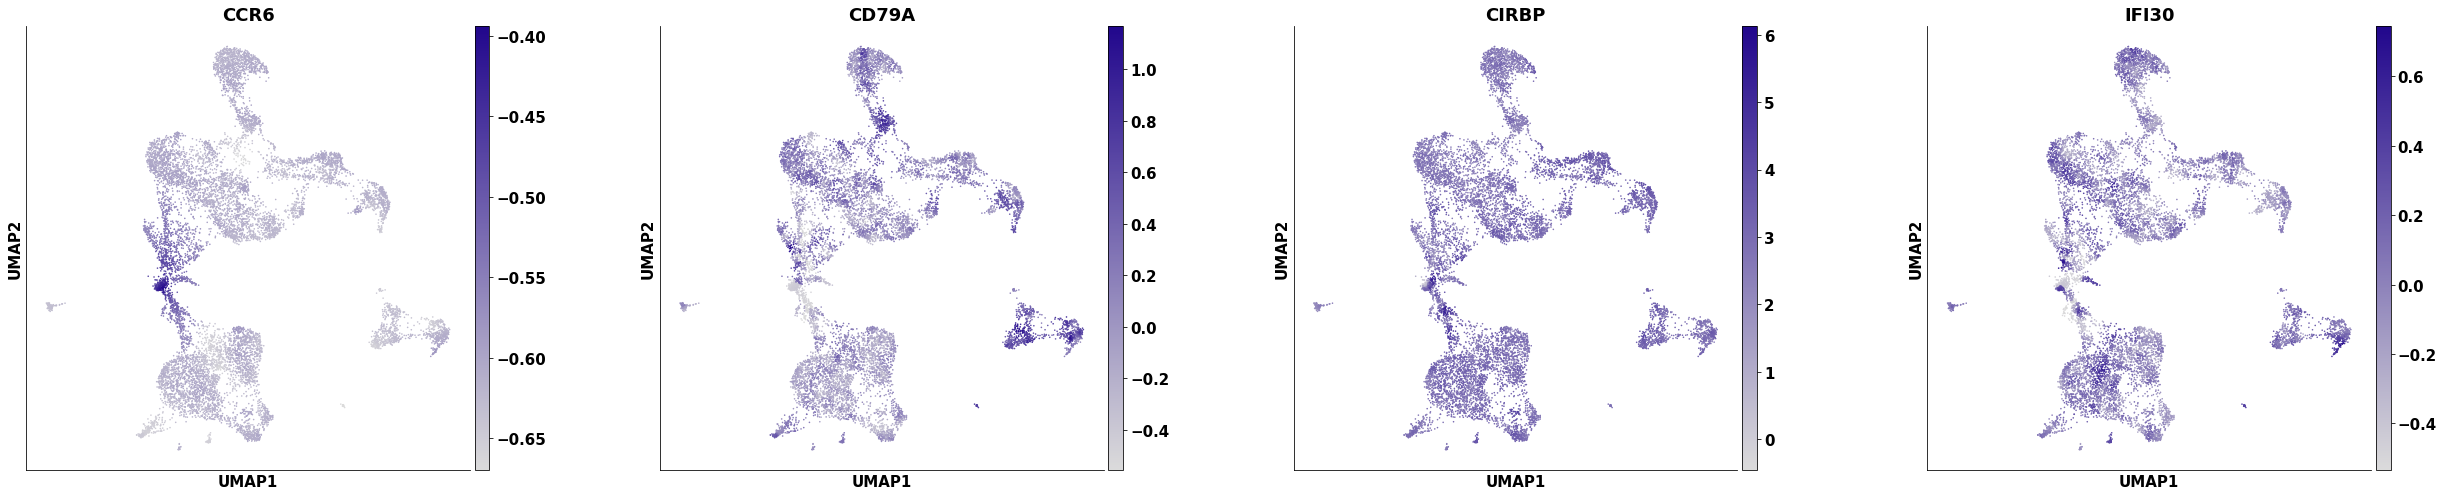

In [707]:
# for i in ['STAT1','CD86','IRF5','NOTCH1','CCDC107','IRF9']:
# for i in ['IRF9']:
# sc.pl.umap(plot_adata, color= ['SLAMF7','CD86','IRF5','NOTCH1','MS4A1','CD19','CD79A', 'IGKC'], wspace=0.3, color_map=regulation_cmp)
sc.pl.umap(plot_adata, color= ['CCR6','CD79A','CIRBP','IFI30'], wspace=0.3, color_map=regulation_cmp)

In [924]:
target_gene_list = []
target_gene_list += sub_RP_table_z.max(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list += sub_RP_table_z.std(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list = set(target_gene_list)
tg_list = [g for g in target_gene_list if g in rna_expr.columns] 

In [925]:
cell_barcode_rna = []
for cell in cells_intrest:
    cell_barcode_rna += rna_adata.obs[(rna_adata.obs['assign.ident']==cell)].index.tolist()


keys.index = keys['RNA']
cell_barcode_atac = keys.loc[cell_barcode_rna]['ATAC'].values

cell_barcode_atac = [i for i in cell_barcode_atac if i in pbmc_script_adata.obs.index]

keys.index = keys['ATAC']
cell_barcode_rna = keys.loc[cell_barcode_atac]['RNA'].values

In [926]:
tar_expr = rna_expr.loc[cell_barcode_rna,tg_list + [factor]].copy()

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T

coor = []
pvalue = []
# rp_corr = []
for i in tf_RP.columns:
    tmp = sp.stats.spearmanr(tar_expr[factor], tar_expr[i])
    if not np.isnan(tmp.correlation):
        coor.append(tmp.correlation)
        pvalue.append(tmp.pvalue)
    else:
        coor.append(0)
        pvalue.append(1)
#     tmp1 = sp.stats.spearmanr(tf_RP[i], tar_expr[i])
#     rp_corr.append(tmp1.correlation)

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T.median()

data = pd.DataFrame(np.array([coor,tf_RP, -np.log(pvalue)]).T, columns = ['corr', 'RP', '-log.p'], index = tg_list)

In [916]:
# tf_regu = pbmc_script_adata.obs['I_'+factor].loc[cell_barcode_atac,]

55


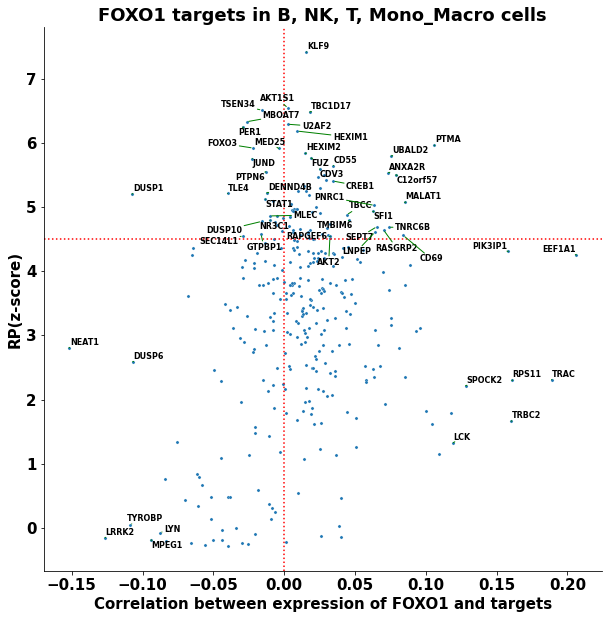

In [927]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x = 'corr', y = 'RP', s=10)

x_q02 = data.iloc[:,0].quantile(0.98)
x_q25 = data.iloc[:,0].quantile(0.75)
x_q75 = data.iloc[:,0].quantile(0.25)
x_q98 = data.iloc[:,0].quantile(0.02)
y_q25 = data.iloc[:,1].quantile(0.75)
y_q05 = data.iloc[:,1].quantile(0.95)

texts = []
for i in range(len(data.index)):
    if data.iloc[i,0] > x_q02:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,0] < x_q98:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q05:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] > x_q25:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] < x_q75:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
print(texts.__len__())
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))

for hl in [y_q25]:
    ax.axhline(hl, linestyle=':', color='red')
for vl in [0]:
    ax.axvline(vl, linestyle=':', color='red')
    
ax.set_xlabel('Correlation between expression of %s and targets' % factor)
ax.set_ylabel('RP(z-score)')
ax.set_title('%s targets in %s cells' % (factor, ', '.join(cells_intrest)))
fig.show()

In [426]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(sub_RP_table)

In [ ]:
# sns.heatmap(sub_RP_table.iloc[0:100,:], xticklabels=False, yticklabels=False, cmap='RdBu_r')

RP11-134P9.3     42.470775
PSME2            41.784596
RNF31            41.532952
RP11-398A8.3     41.301670
GNAI2            39.421524
                   ...    
PRRT2            31.717071
RP11-440L14.1    31.664623
AC009133.23      31.606836
EIF4ENIF1        31.601642
RHOG             31.593741
Length: 100, dtype: float64

In [131]:
a = sub_RP_table.sum(axis=1).sort_values(ascending=False)

In [129]:
sub_RP_table

,AAACTCGAGCGAATAT,AAACTCGAGTCTTAGC,AAAGGGCTCCATGTTT,AAAGGGCTCTTGCGCT,AAATGCCAGCGTTGCC,AACAAAGGTAATGCAA,AACAGTCCAGGCTACC,AACAGTCTCTCTTAAC,AACCAACTCTGACTTT,AACCGATGTACGGATG,...,TTGCTTATCTTCTTCC,TTGGTCCTCGAGGTAG,TTGTTCAAGGCCAGTA,TTGTTGTCATCGACGC,TTGTTGTCATTGAACC,TTTACGTTCCAGCACG,TTTGAGGAGAGCTACG,TTTGAGGGTCATAAGA,TTTGGCCCATTATGGC,TTTGGTTCACAAGGGT
A1BG,0.281810,0.242142,0.369600,0.177019,0.280370,0.203914,0.215248,0.220914,0.143738,0.143738,...,0.094176,0.061615,0.225861,0.276143,0.177739,0.310144,0.099843,0.164966,0.099843,0.253476
A1BG-AS1,0.266700,0.222594,0.345656,0.168841,0.255772,0.189417,0.202018,0.208319,0.136500,0.136500,...,0.090721,0.063845,0.209156,0.260399,0.174305,0.298204,0.097022,0.150775,0.097022,0.235196
A2ML1,0.007843,0.004991,0.009269,0.003565,0.004991,0.004278,0.000713,0.003565,0.004278,0.004278,...,0.007130,0.003565,0.006417,0.004991,0.002852,0.013547,0.004278,0.003565,0.005704,0.006417
A3GALT2,0.000840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000840,0.000000,0.000000,0.000840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,1.401102,0.972065,0.751330,1.483036,1.192243,1.038830,0.833014,1.490917,1.684511,1.684511,...,2.489696,1.577759,0.481178,1.484263,0.754147,1.747224,2.458621,1.314864,1.744892,0.481869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM4,0.565665,0.213596,0.702233,0.520143,0.120645,0.148340,0.324375,0.575532,0.148340,0.148340,...,0.296680,0.176035,0.176035,0.462848,0.213596,0.549743,0.176035,0.306547,0.168074,0.203729
ZSWIM8,0.048418,0.048418,0.110660,0.036314,0.060523,0.060523,0.048802,0.060523,0.036314,0.036314,...,0.096837,0.036314,0.012105,0.085495,0.084732,0.158123,0.048418,0.012868,0.121238,0.024209
ZSWIM8-AS1,0.144136,0.144136,0.329420,0.108102,0.180170,0.180170,0.145279,0.180170,0.108102,0.108102,...,0.288271,0.108102,0.036034,0.254509,0.252238,0.470713,0.144136,0.038305,0.360911,0.072068
ZYG11B,0.020776,0.012466,0.029087,0.027009,0.014543,0.012466,0.016621,0.027009,0.010388,0.010388,...,0.008310,0.010388,0.016621,0.029087,0.018699,0.033242,0.010388,0.012466,0.010388,0.016621


In [ ]:
a[0:50]

In [ ]:
for i in [5, 10, 20, 50, 75, 100]:
    print(i)
    locals()['ret_cell_peak_%s' % str(i)] = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'wb+') as f:
        pickle.dump(locals()['ret_cell_peak_%s' % str(i)], f)
    print_log('Finish saving.')

In [15]:
cells_list = input_mat.index.to_list()

# for i in [50, 75, 100]:
#     print(i)
#     with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%i.pk' % i,'rb+') as f:
#         ret_cell_peak = pickle.load(f)

#     cell_peaks_csr = sp.sparse.csr_matrix(ret_cell_peak)

    genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
    genes_cells_score_csr = genes_peaks_score_csr.dot(ret_cell_peak.T)

    score_cells_dict = {}
    score_cells_sum_dict = {}

    for igene, gene in enumerate(genes_list):
        score_cells_dict[gene] = igene
        score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

    score_cells_dict_dedup = {}
    score_cells_dict_max = {}
    genes = list(set([i.split("@")[0] for i in genes_list]))
    for gene in genes:
        score_cells_dict_max[gene] = float("-inf")

    for gene in genes_list:
        symbol = gene.split("@")[0]
        if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
            score_cells_dict_dedup[symbol] = score_cells_dict[gene]
            score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
    gene_symbol = sorted(score_cells_dict_dedup.keys())
    matrix_row = []
    for gene in gene_symbol:
        matrix_row.append(score_cells_dict_dedup[gene])

    score_cells_matrix = genes_cells_score_csr[matrix_row, :]

    RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)

    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'wb+') as f:
        pickle.dump(RP_table, f)

50
75
100


In [94]:
# write_10X_h5('example/10X_ATAC/RP_impute/RP_5_cell.h5', score_cells_matrix, gene_symbol, cells_list, genome=gene_bed.split("/")[-1].split("_")[0], datatype="Gene")

In [137]:
cell_peaks_csr = sp.sparse.csr_matrix(celltype_peak_mat)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(cell_peaks_csr.T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cell_type)

with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'wb+') as f:
    pickle.dump(RP_table, f)

In [ ]:
RP_table

In [24]:
# plot
# load dataset
with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'rb+') as f:
    cluster_rp = pickle.load(f)
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'rb+') as f:
        locals()['RP_%s_cell' %i] = pickle.load(f)

In [45]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_rp.columns:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_rp.index.__len__(), ct_bc.__len__()]), index=cluster_rp.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_rp[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['RP_%s_cell' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['RP_%s_cell' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [51]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/RP_impute/result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

In [59]:
result_frame[result_frame['cell_type']=='Mono/Macro']

,cell_type,impute_number,difference_sum,std.
0,Mono/Macro,5,75143.564980,0.351939
1,Mono/Macro,10,65312.304338,0.367111
2,Mono/Macro,20,54337.776462,0.362915
3,Mono/Macro,50,39596.649533,0.346345
4,Mono/Macro,75,33217.711931,0.332186
5,Mono/Macro,100,28861.766474,0.318797


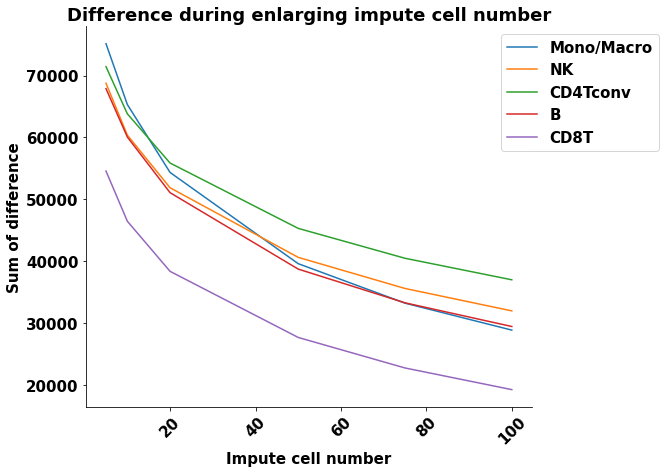

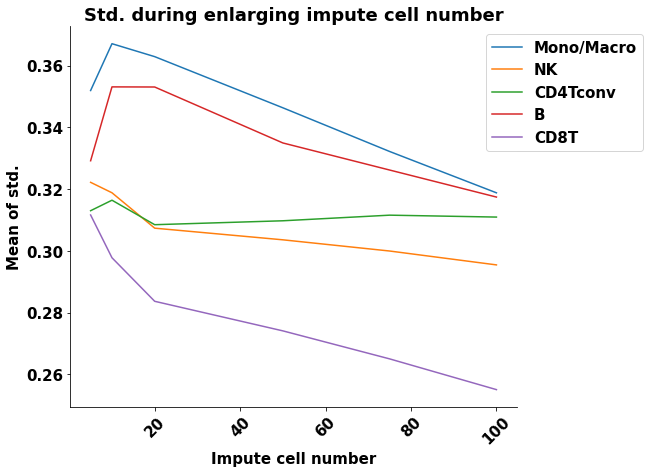

In [90]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

In [73]:
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'rb+') as f:
        locals()['ret_cell_peak_%s' % str(i)] = pickle.load(f)

In [86]:
peak_number = []
for i in [5,10,20,50,75,100]:
    peak_number.append(locals()['ret_cell_peak_%s' % str(i)].sum(1).mean())


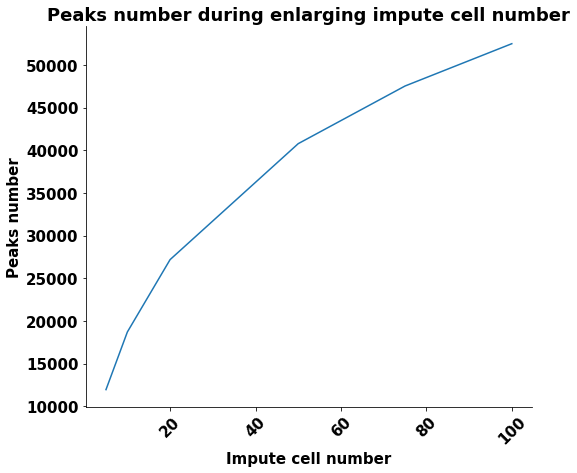

In [89]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(x=[5,10,20,50,75,100], y=peak_number)
plt.xticks(rotation=45)
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Peaks number')
ax.set_title('Peaks number during enlarging impute cell number')
fig.show()

In [ ]:
# plot peak

In [12]:
item = {}
for i in seurat_adata.obs['assign.ident'].unique():
    item[i]=(seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].__len__())

In [41]:
seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].index

427

In [40]:
item

{'CD4Tconv': 2201, 'Mono/Macro': 2920, 'NK': 1240, 'B': 785, 'CD8T': 427}

In [42]:
for k in item.keys():
    generate_beds('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed', seurat_adata.obs[seurat_adata.obs['assign.ident'] == k].index.tolist(), pbmc_10X_inputMat, 5)

In [44]:
for k in item.keys():
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/chip/'+k.replace('/','_')+'.txt', human_chip_index)
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/motif/'+k.replace('/','_')+'.txt', human_motif_index)

In [16]:
for k in item.keys():
    generate_background_bed(pbmc_10X_inputMat, 'example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/'+k.replace('/','_')+'.pk', step=item[k], iteration=1000, peak_confidence=5, n_cores=8)

INFO 2021-02-27 20:13:59 Start generating background beds ...
INFO 2021-02-27 20:46:27 Finished generating background beds!
INFO 2021-02-27 20:46:27 Start generating background beds ...
INFO 2021-02-27 21:23:20 Finished generating background beds!
INFO 2021-02-27 21:23:20 Start generating background beds ...
INFO 2021-02-27 21:45:27 Finished generating background beds!
INFO 2021-02-27 21:45:27 Start generating background beds ...
INFO 2021-02-27 22:02:05 Finished generating background beds!
INFO 2021-02-27 22:02:05 Start generating background beds ...
INFO 2021-02-27 22:15:03 Finished generating background beds!


In [17]:
for k in item.keys():
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', human_chip_index, n_cores=8)
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', human_motif_index, n_cores=8) 

In [21]:
for k in item.keys():
    result_chip = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','wb') as result_file:
        pickle.dump(result_chip, result_file)
    result_motif = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif.pk','wb') as result_file:
        pickle.dump(result_motif, result_file)

INFO 2021-03-01 09:52:39 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:48 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:52 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:04 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:09 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:14 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:20 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:28 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:31 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:41 Reading searching results, using 8 cores...


In [25]:
for k in item.keys():
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','rb') as result_file:
        result_chip = pickle.load(result_file)
    factor_result_chip = map_factor_on_ChIP(result_chip)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip_factor.pk','wb') as result_file:
        pickle.dump(factor_result_chip, result_file)        

INFO 2021-03-01 11:20:25 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:26 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:28 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:30 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:34 Summary result from dataset level to factor level.


In [45]:
cell_type_table = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/foreground/txt/chip', n_cores=1)

INFO 2021-03-01 14:01:45 Reading searching results, using 1 cores...


In [48]:
with open('example/10X_ATAC/activate_impute/result/CD4Tconv_chip.pk','rb') as result_file:
    bg_table = pickle.load(result_file)
cal_rank(cell_type_table['CD4Tconv'][0], bg_table.loc[0,:])

INFO 2021-03-01 14:25:28 chunk 1 calculating ...


IndexingError: Too many indexers

In [61]:
mat = []
for i,k in enumerate(item.keys()):
    n = k.replace('/','_')

    l = []
    with open('example/10X_ATAC/activate_impute/result/%s_chip.pk' % n,'rb') as result_file:
        bg_table = pickle.load(result_file)
    for i in range(cell_type_table[n].__len__()):
        l.append(cal_rank(cell_type_table[n][i], bg_table.iloc[i,:]))
    mat.append(l)

In [ ]:
cell_type_table

In [78]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_table.pk','wb') as file:
    pickle.dump(cell_type_table, file)

In [73]:
df = pd.DataFrame(mat).T

In [79]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_rank_table.pk','wb') as file:
    pickle.dump(df, file)

In [88]:
for i in [5,10,20,50,75,100]:
    tmp = sc.read_h5ad('example/10X_ATAC/SCRIPT_result_20210125_%s/10X_ATAC_script_computed_20210111.h5ad' %i)
    locals()['enrich_%s_table' %i ] = tmp.uns['ChIP_p'].T

In [89]:
enrich_5_table

,AACCTTTCATGGTTTG,AAACTGCGTTTGGATC,AACAGTCAGGTTAACA,AATACGCCAAGTGGCA,AAACTGCAGTTATGAG,AGCCGCAGTTGGGAAC,ATAGTCGTCAGGTCTA,AGTGCGCTCCGGGCAT,AGCGTATCATCCCAAA,ACAAACCCATCAGAAA,...,TTGGTCCTCGACTCGG,TTTACGTTCGTAGCGC,TTACTTGTCCTGTAGA,TTATGTCTCGTTGTAG,TTCGGTCGTTGGGAAC,TTGCGAAAGTCAGGAC,TTGGTCCTCCGAGAGA,TTTGAGGCAGCCACGT,TTAGCGAAGTCACACT,TTCGGTCGTTATGCAC
AATF,0.972,0.063,0.501,0.934,0.268,0.948,0.917,0.650,0.954,0.022,...,0.466,0.168,0.289,0.294,0.363,0.368,0.384,0.791,0.591,0.745
ADNP,0.468,0.087,0.580,0.194,0.001,0.598,0.900,0.506,0.734,0.023,...,0.542,0.005,0.548,0.216,0.022,0.231,0.177,0.593,0.001,0.906
AEBP2,0.862,0.673,0.437,0.786,0.002,0.942,0.898,0.588,0.707,0.022,...,0.152,0.003,0.945,0.870,0.037,0.827,0.027,0.979,0.004,0.743
AFF1,0.889,0.289,0.281,0.322,0.001,0.987,0.760,0.481,0.128,0.017,...,0.027,0.001,0.053,0.405,0.065,0.748,0.041,0.529,0.009,0.641
AFF4,0.955,0.480,0.557,0.965,0.001,0.931,0.851,0.544,0.874,0.028,...,0.231,0.001,0.973,0.275,0.061,0.809,0.066,0.969,0.005,0.724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN5B,0.857,0.698,0.559,0.717,0.206,0.965,0.862,0.738,0.960,0.001,...,0.638,0.022,0.741,0.435,0.123,0.790,0.091,0.956,0.839,0.668
ZTA,0.657,0.362,0.496,0.045,0.778,0.420,0.635,0.318,0.936,0.140,...,0.560,0.537,0.066,0.229,0.930,0.577,0.081,0.406,0.866,0.565
ZXDB,0.993,0.723,0.529,0.990,0.001,0.990,0.945,0.785,0.709,0.094,...,0.243,0.004,0.998,0.868,0.096,0.973,0.085,0.999,0.002,0.911
ZXDC,0.530,0.575,0.484,0.956,0.001,0.888,0.940,0.461,0.647,0.190,...,0.061,0.002,0.976,0.913,0.094,0.996,0.313,0.992,0.010,0.940


In [90]:
cluster_enrich = map_factor_on_ChIP(df)

INFO 2021-03-01 16:45:24 Summary result from dataset level to factor level.


In [95]:
cluster_enrich.columns = ['CD4Tconv','Mono/Macro','NK','B','CD8T']

In [96]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_enrich.columns:
#     ct = ct.replace('_','/')
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_enrich.index.__len__(), ct_bc.__len__()]), index=cluster_enrich.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_enrich[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['enrich_%s_table' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['enrich_%s_table' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [99]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/activate_impute/chip_final_result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

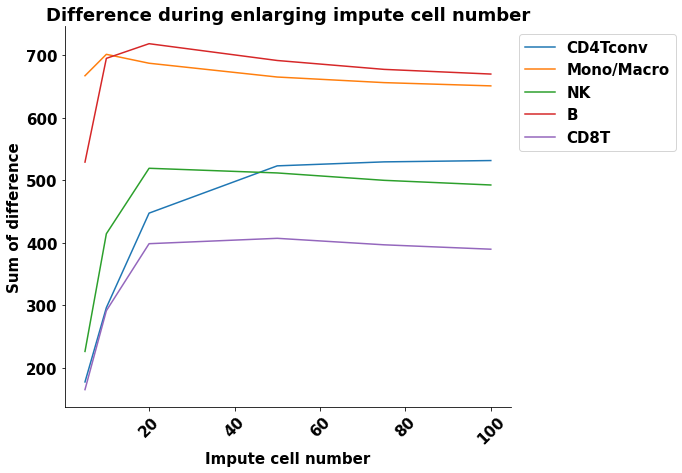

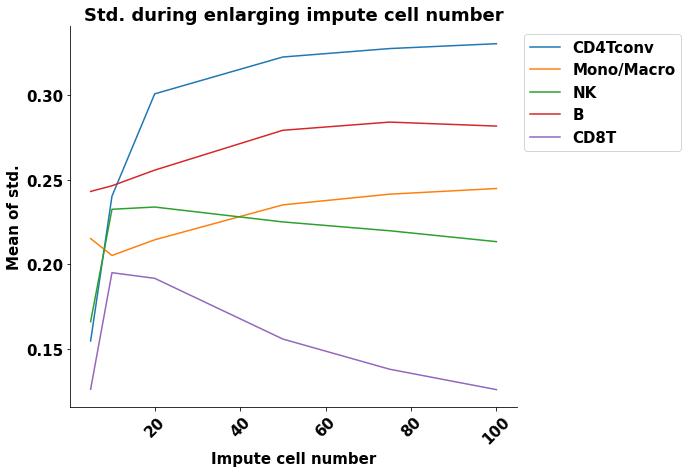

In [103]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

----------
previous code

In [ ]:
CD4T_cluster = input_mat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="CD4Tconv"].index,:]

In [194]:
CD4T_cluster.index

Index(['AAACGAAAGACACGGT', 'AAACGAAAGCTTTCCC', 'AAACGAAAGGCGTCCT',
       'AAACGAAAGTTTGGAA', 'AAACGAACAAACGACG', 'AAACGAATCCAACGCG',
       'AAACGAATCCATCTAT', 'AAACGAATCGGGACAA', 'AAACGAATCTGAACGT',
       'AAACTCGAGAAAGCAG',
       ...
       'TTTGGCCGTGACCAGA', 'TTTGGCCTCGCTCTAC', 'TTTGGTTAGTAATCAG',
       'TTTGGTTGTCAACAGG', 'TTTGGTTGTCGAGGAT', 'TTTGGTTGTCTGCGCA',
       'TTTGGTTGTTCTGAAC', 'TTTGGTTTCAGGCGCT', 'TTTGTGTGTGGCGCTT',
       'TTTGTGTTCGCGCTGA'],
      dtype='object', length=2201)

In [185]:
factor = 'STAT4'

In [195]:
cell_ch = pbmc_script_adata.uns['integrated_z'].loc[CD4T_cluster.index,:].sort_values(by='I_' + factor, ascending=False)['I_' + factor].index.to_list()[0]

In [196]:
cell_ch

'CCTGGGACAACCTCCT'

In [206]:
motif_pattern = get_motif_pattern_from_minimal('/mnt/Storage2/home/dongxin/Projects/motif/human_cisBP/meme/%s.meme' % factor)
result = pd.read_csv('example/10X_ATAC/temp/test/fg_chip_result/%s.txt' % cell_ch, sep='\t', index_col = False).sort_values('combo_score', ascending=False)
bulk_bed = result[[factor in i for i in result['#file']]]['#file'].to_list()[0]
# CGGACCATCCACACCT = pyranges.read_bed('10X_ATAC/temp/test/fg_bed/CGGACCATCCACACCT.bed.gz')
bulk_peak = pyranges.read_bed('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/' + bulk_bed)
cell_peak = pyranges.from_dict(pd.DataFrame([i.split('_') for i in input_mat.index[input_mat.loc[:,cell_ch] >= 1]]).rename(columns={0:'Chromosome', 1:'Start', 2:'End'}))
cell_peak_ovlp_with_bluk = cell_peak.overlap(bulk_peak)

cell_peak_unique = cell_peak.overlap(bulk_peak, invert=True)
cell_peak_unique_motif = filter_motif_peaks(cell_peak_unique,motif_pattern)
tmp = pyranges.from_dict(pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df]))

In [208]:
tmp.to_bed('example/10X_ATAC/temp/%s_%s.bed' % (factor, cell_ch))

In [210]:
os.system('python ~/Projects/cidc_chips/modules/scripts/targets_RegPotential_Version2.py -p example/10X_ATAC/temp/%s_%s.bed -a /mnt/Storage/home/dongxin/Storage2/Files/ref_files/hg38/hg38_refGene.bed -n example/10X_ATAC/temp/%s_%s_gene_score.txt' % (factor, cell_ch,factor, cell_ch))

0

In [153]:
peak = pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df])

,Chromosome,Start,End
1,chr1,103525148,103526464
2,chr1,107940936,107941713
3,chr1,108041499,108042115
5,chr1,108561836,108562005
7,chr1,109041377,109042498
...,...,...,...
1003,chrX,47144364,47145706
1004,chrX,49155865,49156655
1005,chrX,54639307,54640093
1006,chrX,72572385,72573360


In [445]:
# result = read_SingleCellExperiment_rds('example/small_HSC/HSC_single_cell_experiment.rds')
result.write_h5ad('example/small_HSC/HSC_single_cell_experiment.h5ad')

In [451]:
result.obs

,orig.ident,nCount_ATAC,nFeature_ATAC,ATAC_snn_res.0.6,seurat_clusters,ident
singles-BM0828-CMP-frozen-1511,example/small_HSC/ATAC,1805.0,1805,0,0,0
BM1077-CMP-Frozen-160106-3,example/small_HSC/ATAC,3671.0,3671,0,0,0
singles-20160617-scATAC-BM1077,example/small_HSC/ATAC,8163.0,8163,1,1,1
singles-160818-BM1137-pDC-LS-7,example/small_HSC/ATAC,14085.0,14085,6,6,6
singles-20160617-scATAC-BM1077.1,example/small_HSC/ATAC,5320.0,5320,1,1,1
...,...,...,...,...,...,...
singles-BM1214-MCP-frozen-1601.95,example/small_HSC/ATAC,2393.0,2393,6,6,6
singles-20160726-scATAC-BM1214.89,example/small_HSC/ATAC,3425.0,3425,0,0,0
singles-20160726-scATAC-BM1214.90,example/small_HSC/ATAC,3184.0,3184,7,7,7
BM1077-GMP-Frozen-160107-61,example/small_HSC/ATAC,3402.0,3402,5,5,5


In [477]:
data = sc.read_10x_h5('example/small_HSC/GSE96772_HSC_merged_count.h5', gex_only=False )
data.obs_names_make_unique(join='.')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [478]:
data.write_h5ad('example/small_HSC/GSE96772_HSC_merged_count.h5')

""
singles-BM0828-CMP-frozen-1511
BM1077-CMP-Frozen-160106-3
singles-20160617-scATAC-BM1077
singles-160818-BM1137-pDC-LS-7
singles-20160617-scATAC-BM1077.1
...
singles-BM1214-MCP-frozen-1601.95
singles-20160726-scATAC-BM1214.89
singles-20160726-scATAC-BM1214.90
BM1077-GMP-Frozen-160107-61


In [3]:
def peak_norm_matrix(index_peak_number_path, peaks_number_path):
    index_peak_number = pd.read_csv(index_peak_number_path, sep='\t', header=None, index_col=0)
    data_peak_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)

    peak_cell_index_norm_table = pd.DataFrame(np.zeros([index_peak_number.index.__len__(), data_peak_number.index.__len__()]),
                                              index=index_peak_number.index, columns=data_peak_number.index)
    
    for dts in peak_cell_index_norm_table.index:
        dts_number = index_peak_number.loc[dts, 1]
        peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in data_peak_number[1]]
    peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=index_peak_number.index, columns=data_peak_number.index)

    peak_number_dts_mean_value = data_peak_number[1].mean()
    peak_number_dts_norm_series = data_peak_number[1].apply(lambda x: 2**-(abs(x-peak_number_dts_mean_value)/x))
    peak_number_dts_norm_series = peak_number_dts_norm_series.reindex(index=data_peak_number.index)
    
    peak_number_norm_coef = peak_cell_index_norm_table * peak_number_dts_norm_series

    return peak_number_norm_coef

In [5]:
peak_norm_matrix('/mnt/Storage/home/dongxin/Projects/scATAC/index/human_ChIP_index/peaks_number.txt', 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_peaks_number.txt')

,singles-BM1214-GMP-160421-79,singles-BM0106-HSC-LS-160219-1,singles-BM1214-MCP-frozen-160128-35,singles-BM0828-CLP-frozen-151103-33,singles-BM1214-MCP-frozen-160128-28,singles-BM1214-MCP-frozen-160128-18,singles-20160726-scATAC-BM1137-GMP3high-HYC-36,singles-20160617-scATAC-BM1214-CMP-LS-65,singles-BM0828-CMP-frozen-151118-78,singles-BM1214-GMP-160421-68,...,BM1077-HSC-Frozen-160105-3,singles-BM0828-MEP-160420-41,singles-BM0828-CLP-frozen-151103-77,singles-BM0106-HSC-SIM-160219-89,singles-BM1214-GMP-160421-63,singles-BM0106-UNK-160418-92,singles-BM0828-CLP-frozen-151103-67,singles-BM1214-GMP-160421-83,singles-BM0828-MEP-160420-52,singles-BM0828-MEP-160420-6
0,,,,,,,,,,,,,,,,,,,,,
1006_EOMES,0.752326,0.550289,0.683618,0.085193,0.672190,0.072193,0.246514,0.011778,0.000286,0.208753,...,0.677532,0.687518,0.344707,0.241849,0.353290,0.199124,0.164260,0.458132,0.381038,0.694846
1007_EP300,0.752552,0.550454,0.683823,0.085219,0.672391,0.072215,0.246588,0.011781,0.000287,0.208815,...,0.677329,0.687724,0.344810,0.241922,0.353396,0.199184,0.164309,0.457994,0.380924,0.695055
1010_FOXH1,0.753155,0.550895,0.684371,0.085287,0.672930,0.072273,0.246786,0.011791,0.000287,0.208983,...,0.676786,0.688275,0.345087,0.242116,0.353679,0.199343,0.164441,0.457628,0.380619,0.695612
1011_FOXH1,0.756716,0.553500,0.687607,0.085690,0.676112,0.072615,0.247953,0.011846,0.000288,0.209971,...,0.673601,0.691530,0.346718,0.243261,0.355352,0.200286,0.165219,0.455474,0.378828,0.698901
1012_FOXP1,0.759314,0.555400,0.689967,0.085984,0.678433,0.072864,0.248804,0.011887,0.000289,0.210692,...,0.671297,0.693904,0.347909,0.244096,0.356571,0.200973,0.165786,0.453916,0.377532,0.701300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509_TFAP2C,0.753230,0.550950,0.684439,0.085295,0.672997,0.072280,0.246810,0.011792,0.000287,0.209003,...,0.676719,0.688344,0.345121,0.242140,0.353715,0.199363,0.164457,0.457582,0.380581,0.695681
9510_TFAP2C,0.752476,0.550399,0.683754,0.085210,0.672324,0.072208,0.246563,0.011780,0.000287,0.208794,...,0.677396,0.687655,0.344776,0.241898,0.353361,0.199164,0.164293,0.458040,0.380962,0.694985
955_NANOG,0.752928,0.550730,0.684165,0.085261,0.672728,0.072251,0.246712,0.011787,0.000287,0.208920,...,0.676990,0.688068,0.344983,0.242043,0.353573,0.199283,0.164392,0.457765,0.380734,0.695403
